In [2]:
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import cv2
import pandas as pd
# Modelo preentrenado
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import resnet18
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
from PIL import Image
from sklearn.model_selection import train_test_split
from skimage.filters import threshold_otsu
from skimage import measure
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler



## Exploraci√≥n de los datos

In [17]:
train_df = pd.read_csv('../data/train.csv')
test_df = pd.read_csv(r'../data/test.csv')


base_path=r'notebooks/train_images'

# Se guarda el path de las imagenes dentro del dataframe
train_df['img_path']= f'{base_path}'\
                    + '/' + train_df.patient_id.astype(str)\
                    + '/' + train_df.image_id.astype(str)\
                    + '.png'



display(train_df.head(3))

site_id  patient_id    image_id laterality view  age  cancer  biopsy  \
0        2       10006   462822612          L   CC   61       0       0   
1        2       10006  1459541791          L  MLO   61       0       0   
2        2       10006  1864590858          R  MLO   61       0       0   

   invasive  BIRADS  implant density  machine_id  difficult_negative_case  \
0         0     NaN        0     NaN          29                    False   
1         0     NaN        0     NaN          29                    False   
2         0     NaN        0     NaN          29                    False   

                                      img_path  
0   notebooks/train_images/10006/462822612.png  
1  notebooks/train_images/10006/1459541791.png  
2  notebooks/train_images/10006/1864590858.png

In [33]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54706 entries, 0 to 54705
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   site_id                  54706 non-null  int64  
 1   patient_id               54706 non-null  int64  
 2   image_id                 54706 non-null  int64  
 3   laterality               54706 non-null  object 
 4   view                     54706 non-null  object 
 5   age                      54706 non-null  int64  
 6   cancer                   54706 non-null  int64  
 7   biopsy                   54706 non-null  int64  
 8   invasive                 54706 non-null  int64  
 9   BIRADS                   26286 non-null  float64
 10  implant                  54706 non-null  int64  
 11  density                  29470 non-null  object 
 12  machine_id               54706 non-null  int64  
 13  difficult_negative_case  54706 non-null  bool   
 14  img_path              

Existen variables con valores nulos que seg√∫n la literatura podr√≠an tener gran incidencia en la identificaci√≥n del cancer en la mama, c√≥mo la clasificaci√≥n BIRADS y la densidad de la mama.

La clasificaci√≥n BIRADS:
+ 0: Si la mama requiri√≥ seguimiento
+ 1: Si la mama fue calificada como negativo para cancer
+ 2: Si la mama fue calificada como  normal

Density: "Densidad"
Calificaci√≥n que indica que tan denso es el tejido mamario. 
+ Iniciando en A para los casos en donde la mama es la menos densa y D para los mas densos.

In [34]:
train_df.describe()

site_id    patient_id      image_id           age        cancer  \
count  54706.000000  54706.000000  5.470600e+04  54706.000000  54706.000000   
mean       1.460407  32698.865262  1.079386e+09     58.538149      0.021168   
std        0.498434  18893.861534  6.183269e+08     10.049939      0.143944   
min        1.000000      5.000000  6.849100e+04     26.000000      0.000000   
25%        1.000000  16481.000000  5.458153e+08     51.000000      0.000000   
50%        1.000000  32432.000000  1.082689e+09     59.000000      0.000000   
75%        2.000000  48999.000000  1.613228e+09     66.000000      0.000000   
max        2.000000  65534.000000  2.147472e+09     89.000000      1.000000   

             biopsy      invasive        BIRADS       implant    machine_id  
count  54706.000000  54706.000000  26286.000000  54706.000000  54706.000000  
mean       0.054272      0.014953      0.772350      0.026999     54.618378  
std        0.226556      0.121365      0.590062      0.162081     44.784800  
min        0.000000      0.000000      0.000000      0.000000     21.000000  
25%        0.000000      0.000000      0.000000      0.000000     29.000000  
50%        0.000000      0.000000      1.000000      0.000000     49.000000  
75%        0.000000      0.000000      1.000000      0.000000     49.000000  
max        1.000000      1.000000      2.000000      1.000000    216.000000

+ **site_id**: Indica el sitio donde se recolectaron los datos. Hay dos sitios (m√≠nimo 1, m√°ximo 2). La mayor√≠a de los registros provienen del sitio 1, como se deduce por la mediana (50%) y el 25% y 75% iguales a 1.
+ **patient_id**: Identifica a los pacientes. Los valores van desde 5 hasta 65,534, probablemente identificadores √∫nicos. Hay 54,706 pacientes en total.
+ image_id: Representa los identificadores de las im√°genes. Los valores son grandes n√∫meros enteros (probablemente IDs generados). Su rango es amplio, desde 68,491 hasta 2,147,472,000.
+ **age**: Variable binaria que indica si hay diagn√≥stico de c√°ncer (1: S√≠, 0: No). Promedio: 0.021, lo que implica que el 2.1% de las observaciones tienen un diagn√≥stico positivo. M√°ximo: 1 (presencia de c√°ncer).
+ **biopsy**: Indica si el paciente tuvo una biopsia. Promedio: 0.054, lo que implica que el 5.4% de las observaciones incluyen biopsias realizadas. M√°ximo: 1 (s√≠ tuvo biopsia).
+ **invasive**: Indica si el c√°ncer es invasivo. Promedio: 0.015, lo que implica que el 1.5% de las observaciones tienen diagn√≥stico de c√°ncer invasivo. M√°ximo: 1 (presencia de invasi√≥n).
+ **BIRADS**: Puntuaci√≥n BI-RADS para categorizar im√°genes de mamograf√≠a. Datos disponibles para 26,286 registros. Promedio: 0.77 (lo que puede sugerir una concentraci√≥n en categor√≠as bajas). Rango: 0 (sin categor√≠a asignada) a 2 (categor√≠a m√°s alta presente en el conjunto).
+ **implant**: Indica si el paciente tiene implantes mamarios. Promedio: 0.027, lo que implica que el 2.7% de las observaciones corresponden a pacientes con implantes. M√°ximo: 1 (presencia de implantes).
+ **machine_id**: Identifica el equipo o m√°quina utilizada para la mamograf√≠a. Promedio: 54.62. Rango: 21 a 216, lo que sugiere una gran diversidad de m√°quinas utilizadas.

Puntos claves:

+ La mayor√≠a de los pacientes tienen m√°s de 50 a√±os.
+ Los casos positivos de c√°ncer (2.1%) y biopsias (5.4%) son relativamente pocos en comparaci√≥n con el tama√±o total del conjunto de datos.
+ Hay datos faltantes en la columna BIRADS, ya que solo tiene 26,286 valores registrados de 54,706 posibles.
+ Se observan caracter√≠sticas poblacionales y tecnol√≥gicas (edad avanzada de los pacientes, gran diversidad de m√°quinas)

## Preprocesamiento

La clasificaci√≥n BI-RADS es un componente crucial en el an√°lisis de mamograf√≠as, ya que proporciona una evaluaci√≥n estandarizada del riesgo y orienta las decisiones cl√≠nicas.

La ausencia de este dato para pacientes con c√°ncer podr√≠a dificultar el an√°lisis de la severidad o el tipo de lesi√≥n detectada.

In [35]:
patients_with_nan_BIRADS = train_df[train_df['BIRADS'].isna()]
patients_with_cancer_nan_BIRADS = patients_with_nan_BIRADS[patients_with_nan_BIRADS['cancer'] == 1]

# Cantidad de pancientes con cancer y clasificaci√≥n BIRADS nan
print(len(patients_with_cancer_nan_BIRADS))

494


In [36]:
# Analizar la distribuci√≥n de BI-RADS (asume que es una columna llamada 'BIRADS')
birads = train_df['BIRADS'].dropna()

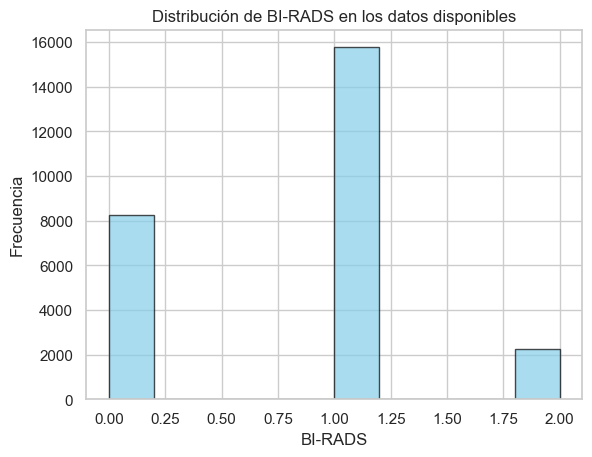

In [37]:
# Analizar la distribuci√≥n existente
plt.hist(birads, bins=10, color='skyblue', edgecolor='black', alpha=0.7)
plt.title('Distribuci√≥n de BI-RADS en los datos disponibles')
plt.xlabel('BI-RADS')
plt.ylabel('Frecuencia')
plt.show()

**Analisis distribuci√≥n**
- La categor√≠a 1.0 es la m√°s prevalente, con m√°s de 16,000 registros.
- La categor√≠a 0.0 tambi√©n tiene una representaci√≥n considerable, con alrededor de 8,000 registros.
- La categor√≠a 2.0 tiene la menor cantidad de registros, en comparaci√≥n con las otras dos.

**Simulaci√≥n de montecarlo b√°sica para valores faltantes**

1. calcular las probabilidades de cada categor√≠a de BI-RADS (0, 1, 2) con base en su frecuencia relativa en los datos disponibles.
2. Usar estas probabilidades para imputar valores faltantes de manera aleatoria, manteniendo las proporciones observadas en los datos originales.

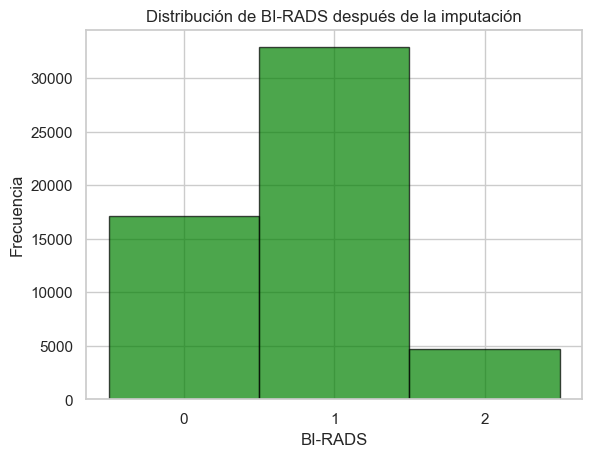

In [38]:
# Calcular las probabilidades din√°micamente
available_birads = train_df['BIRADS'].dropna()  # Valores disponibles
birads_probs = available_birads.value_counts(normalize=True).sort_index().to_list()

# Funci√≥n para simular valores faltantes
def simulate_categorical_birads(size, probs):
    categories = [0, 1, 2]  # Los valores posibles de BI-RADS
    simulated_values = np.random.choice(categories, size=size, p=probs)
    return simulated_values

np.random.seed(42)  # Para reproducibilidad

# Identificar los √≠ndices con valores faltantes
missing_indices = train_df[train_df['BIRADS'].isnull()].index
num_missing = len(missing_indices)

# Simular los valores faltantes usando las probabilidades din√°micas
simulated_birads = simulate_categorical_birads(num_missing, birads_probs)

# Imputar los valores simulados
train_df.loc[missing_indices, 'BIRADS'] = simulated_birads

# Visualizar la distribuci√≥n despu√©s de la imputaci√≥n
plt.hist(train_df['BIRADS'], bins=[-0.5, 0.5, 1.5, 2.5], color='green', edgecolor='black', alpha=0.7)
plt.xticks([0, 1, 2])
plt.title('Distribuci√≥n de BI-RADS despu√©s de la imputaci√≥n')
plt.xlabel('BI-RADS')
plt.ylabel('Frecuencia')
plt.show()

**Distribuci√≥n despu√©s de la imputaci√≥n:**

- La distribuci√≥n se ajusta a las proporciones originales calculadas antes de la imputaci√≥n:
- La categor√≠a 1.0 sigue siendo la m√°s prevalente.
- Las categor√≠as 0.0 y 2.0 tienen menor representaci√≥n, como en los datos originales.

Este m√©todo asume que los valores faltantes son completamente aleatorios y que su distribuci√≥n sigue las probabilidades observadas. 

In [39]:
# Comparar distribuciones
original_distribution = available_birads.value_counts(normalize=True).sort_index()
imputed_distribution = train_df['BIRADS'].value_counts(normalize=True).sort_index()

comparison = pd.DataFrame({
    'Original': original_distribution,
    'Imputed': imputed_distribution
})
print(comparison)

        Original   Imputed
BIRADS                    
0.0     0.313817  0.312690
1.0     0.600015  0.601122
2.0     0.086168  0.086188


Validaci√≥n de nulos en variable densidad

In [40]:
# Ver valores √∫nicos y frecuencias
print(train_df['density'].value_counts())

density
B    12651
C    12175
A     3105
D     1539
Name: count, dtype: int64


In [41]:
#C√°lculo de las probabilidades dinamicamente
# Filtrar los datos disponibles
available_density = train_df['density'].dropna()

# Calcular las frecuencias relativas
density_probs = available_density.value_counts(normalize=True).sort_index().to_list()
print(f"Probabilidades calculadas din√°micamente: {density_probs}")

Probabilidades calculadas din√°micamente: [0.10536138445877163, 0.4292840176450628, 0.41313199864268746, 0.052222599253478115]


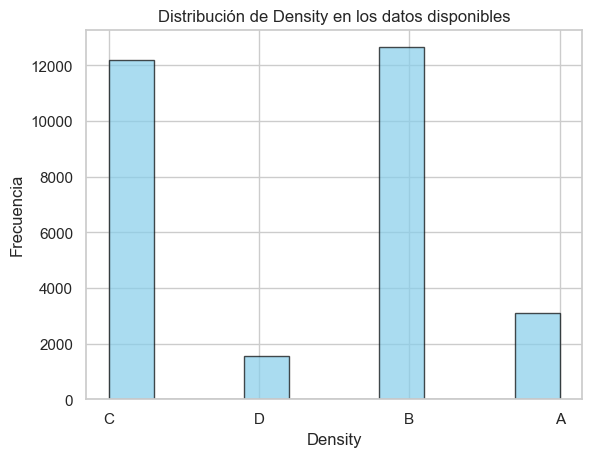

In [42]:
# Analizar la distribuci√≥n existente
plt.hist(available_density, bins=10, color='skyblue', edgecolor='black', alpha=0.7)
plt.title('Distribuci√≥n de Density en los datos disponibles')
plt.xlabel('Density')
plt.ylabel('Frecuencia')
plt.show()

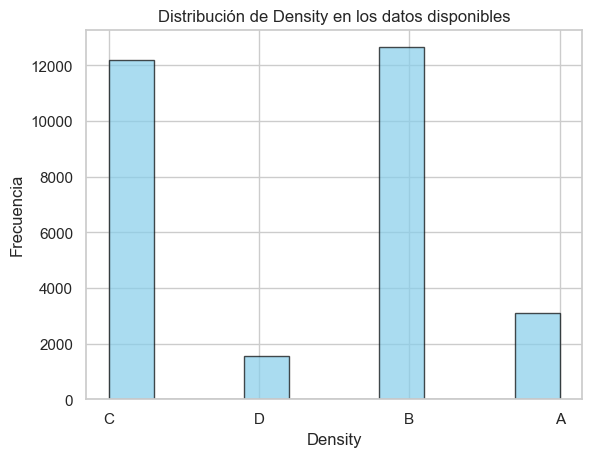

In [43]:
# Analizar la distribuci√≥n existente
plt.hist(available_density, bins=10, color='skyblue', edgecolor='black', alpha=0.7)
plt.title('Distribuci√≥n de Density en los datos disponibles')
plt.xlabel('Density')
plt.ylabel('Frecuencia')
plt.show()

In [44]:
#Validamos la imputaci√≥n
# Distribuciones original e imputada
original_density_distribution = available_density.value_counts(normalize=True).sort_index()
imputed_density_distribution = train_df['density'].value_counts(normalize=True).sort_index()

# Crear comparaci√≥n
density_comparison = pd.DataFrame({
    'Original': original_density_distribution,
    'Imputed': imputed_density_distribution
})
print(density_comparison)

         Original   Imputed
density                    
A        0.105361  0.105361
B        0.429284  0.429284
C        0.413132  0.413132
D        0.052223  0.052223


cancer
0    53548
1     1158
Name: count, dtype: int64


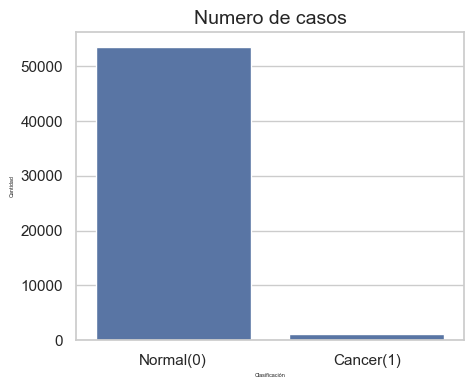

In [45]:
cases_count = train_df['cancer'].value_counts()
print(cases_count)

# Plot the results 
plt.figure(figsize=(5,4))
sns.barplot(x=cases_count.index, y= cases_count.values)
plt.title('Numero de casos', fontsize=14)
plt.xlabel('Clasificaci√≥n', fontsize=4)
plt.ylabel('Cantidad', fontsize=4)
plt.xticks(range(len(cases_count.index)), ['Normal(0)', 'Cancer(1)'])
plt.show()

**Visualizaci√≥n del conjunto de imagenes:**

Primera fila imagenes con cancer
Segunda fila imegenes sin cancer

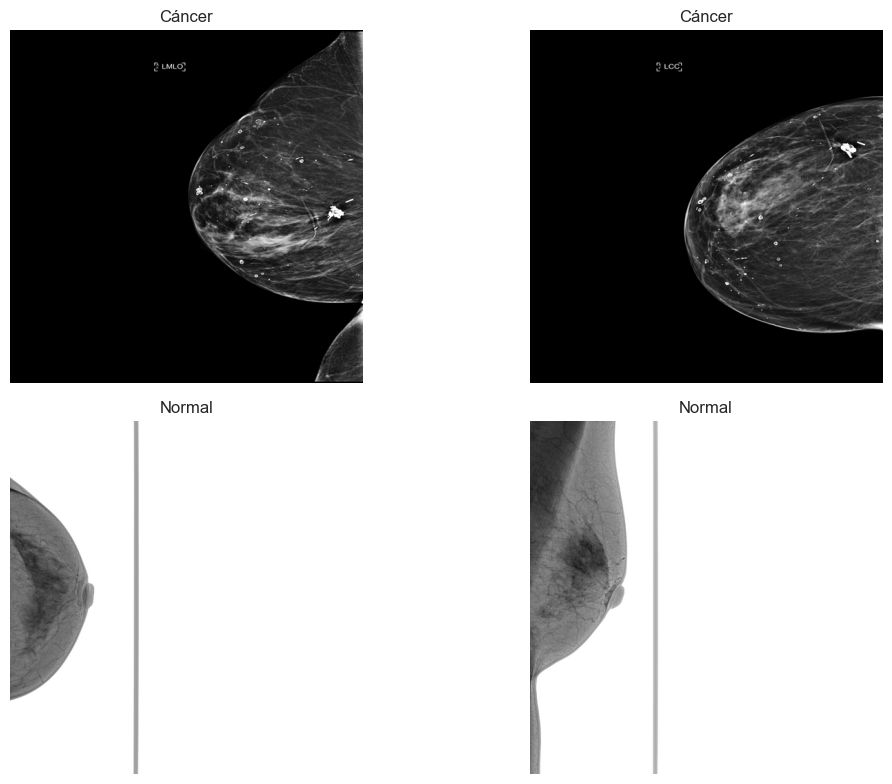

In [46]:
# Visualizar im√°genes clasificadas como C√°ncer y No C√°ncer
Cancer_samples = (train_df[train_df['cancer'] == 1]['img_path'].iloc[0:2]).tolist()
Normal_samples = (train_df[train_df['cancer'] == 0]['img_path'].iloc[0:2]).tolist()

samples = Cancer_samples + Normal_samples

# Mostrar en 2x2
f, ax = plt.subplots(2, 2, figsize=(12, 8))

for i in range(4):
    img = tf.keras.preprocessing.image.load_img(samples[i])
    ax[i // 2, i % 2].imshow(img, cmap='gray')
    
    label = "C√°ncer" if i < 2 else "Normal"
    ax[i // 2, i % 2].set_title(label)
    ax[i // 2, i % 2].axis('off')

plt.tight_layout()
plt.show()


Histogramas de pacientes con y sin cancer para visualizar distribuci√≥n, media, mediana, minimo y maximo por tipo de diagnostico

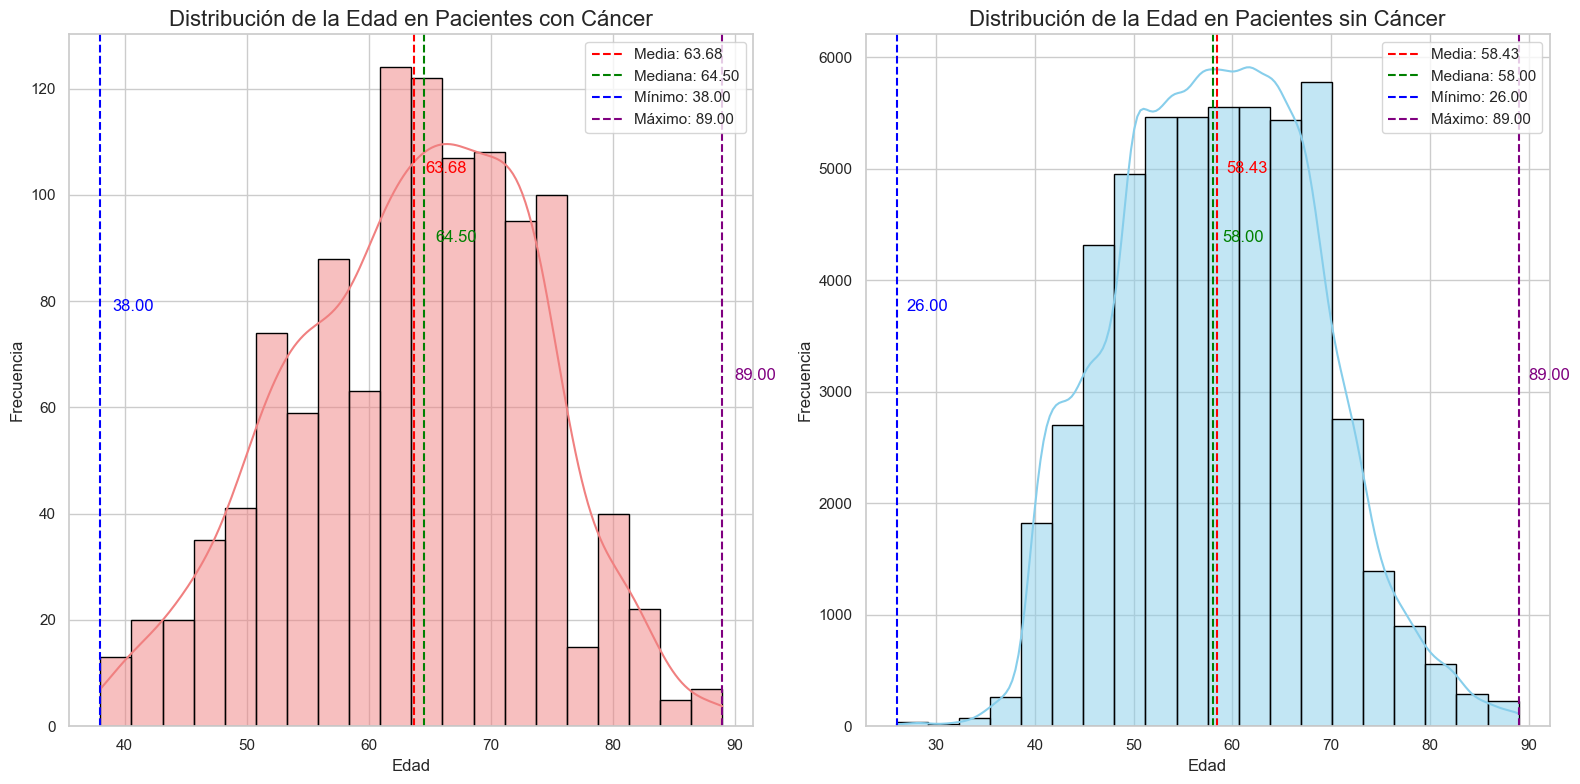

In [47]:
# Separar los datos entre pacientes con c√°ncer y sin c√°ncer
cancer_df = train_df[train_df['cancer'] == 1]
no_cancer_df = train_df[train_df['cancer'] == 0]

# Crear una figura con dos gr√°ficos (uno para c√°ncer, otro para no c√°ncer)
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# --- Gr√°fico para pacientes con c√°ncer ---
sns.histplot(cancer_df['age'], kde=True, bins=20, color='lightcoral', edgecolor='black', ax=axes[0])

# Calcular estad√≠sticos para pacientes con c√°ncer
mean_age_cancer = cancer_df['age'].mean()
median_age_cancer = cancer_df['age'].median()
min_age_cancer = cancer_df['age'].min()
max_age_cancer = cancer_df['age'].max()

# A√±adir l√≠neas de estad√≠sticos
axes[0].axvline(mean_age_cancer, color='red', linestyle='--', label=f'Media: {mean_age_cancer:.2f}')
axes[0].axvline(median_age_cancer, color='green', linestyle='--', label=f'Mediana: {median_age_cancer:.2f}')
axes[0].axvline(min_age_cancer, color='blue', linestyle='--', label=f'M√≠nimo: {min_age_cancer:.2f}')
axes[0].axvline(max_age_cancer, color='purple', linestyle='--', label=f'M√°ximo: {max_age_cancer:.2f}')
# A√±adir anotaciones
axes[0].text(mean_age_cancer + 1, axes[0].get_ylim()[1] * 0.8, f'{mean_age_cancer:.2f}', color='red')
axes[0].text(median_age_cancer + 1, axes[0].get_ylim()[1] * 0.7, f'{median_age_cancer:.2f}', color='green')
axes[0].text(min_age_cancer + 1, axes[0].get_ylim()[1] * 0.6, f'{min_age_cancer:.2f}', color='blue')
axes[0].text(max_age_cancer + 1, axes[0].get_ylim()[1] * 0.5, f'{max_age_cancer:.2f}', color='purple')

# T√≠tulo y etiquetas para pacientes con c√°ncer
axes[0].set_title('Distribuci√≥n de la Edad en Pacientes con C√°ncer', fontsize=16)
axes[0].set_xlabel('Edad', fontsize=12)
axes[0].set_ylabel('Frecuencia', fontsize=12)
axes[0].legend()

# --- Gr√°fico para pacientes sin c√°ncer ---
sns.histplot(no_cancer_df['age'], kde=True, bins=20, color='skyblue', edgecolor='black', ax=axes[1])

# Calcular estad√≠sticos para pacientes sin c√°ncer
mean_age_no_cancer = no_cancer_df['age'].mean()
median_age_no_cancer = no_cancer_df['age'].median()
min_age_no_cancer = no_cancer_df['age'].min()
max_age_no_cancer = no_cancer_df['age'].max()
# A√±adir l√≠neas de estad√≠sticos
axes[1].axvline(mean_age_no_cancer, color='red', linestyle='--', label=f'Media: {mean_age_no_cancer:.2f}')
axes[1].axvline(median_age_no_cancer, color='green', linestyle='--', label=f'Mediana: {median_age_no_cancer:.2f}')
axes[1].axvline(min_age_no_cancer, color='blue', linestyle='--', label=f'M√≠nimo: {min_age_no_cancer:.2f}')
axes[1].axvline(max_age_no_cancer, color='purple', linestyle='--', label=f'M√°ximo: {max_age_no_cancer:.2f}')

# A√±adir anotaciones
axes[1].text(mean_age_no_cancer + 1, axes[1].get_ylim()[1] * 0.8, f'{mean_age_no_cancer:.2f}', color='red')
axes[1].text(median_age_no_cancer + 1, axes[1].get_ylim()[1] * 0.7, f'{median_age_no_cancer:.2f}', color='green')
axes[1].text(min_age_no_cancer + 1, axes[1].get_ylim()[1] * 0.6, f'{min_age_no_cancer:.2f}', color='blue')
axes[1].text(max_age_no_cancer + 1, axes[1].get_ylim()[1] * 0.5, f'{max_age_no_cancer:.2f}', color='purple')

# T√≠tulo y etiquetas para pacientes sin c√°ncer
axes[1].set_title('Distribuci√≥n de la Edad en Pacientes sin C√°ncer', fontsize=16)
axes[1].set_xlabel('Edad', fontsize=12)
axes[1].set_ylabel('Frecuencia', fontsize=12)
axes[1].legend()
# Mostrar el gr√°fico
plt.tight_layout()
plt.show()

**Matriz de correlaci√≥n**

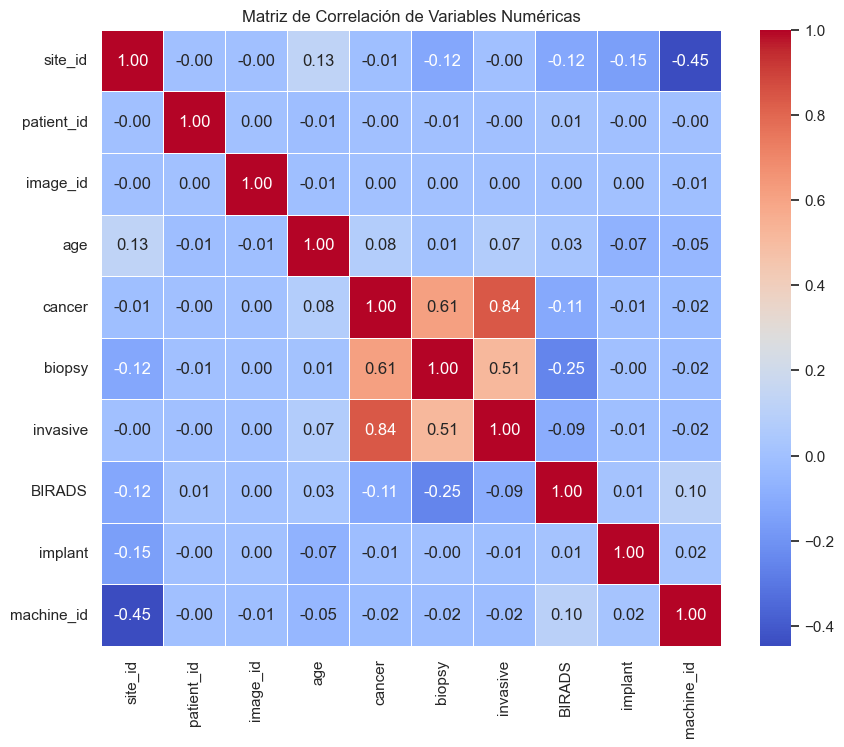

In [48]:
# Seleccionar solo las columnas num√©ricas del DataFrame
numeric_df = train_df.select_dtypes(include=['float64', 'int64'])

# Calcular la matriz de correlaci√≥n
corr_matrix = numeric_df.corr()

# Crear el gr√°fico de correlaci√≥n
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Matriz de Correlaci√≥n de Variables Num√©ricas')
plt.show()

* Las correlaciones fuertes entre cancer, invasive, y biopsy confirman su estrecha relaci√≥n cl√≠nica. Esto implica que estas variables est√°n alineadas con el flujo normal del diagn√≥stico y tratamiento del c√°ncer.

* La correlaci√≥n negativa moderada entre BI-RADS y biopsy destaca el valor de BI-RADS como un predictor inicial para decidir pruebas adicionales.

* La relaci√≥n entre site_id y machine_id sugiere diferencias entre los sitios en t√©rminos de tecnolog√≠a o metodolog√≠a, que podr√≠an introducir sesgos en los datos. 

C:\Users\Melissa\AppData\Local\Temp\ipykernel_57704\3099771393.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='cancer', y='age', data=train_df, palette=['blue', 'red'])


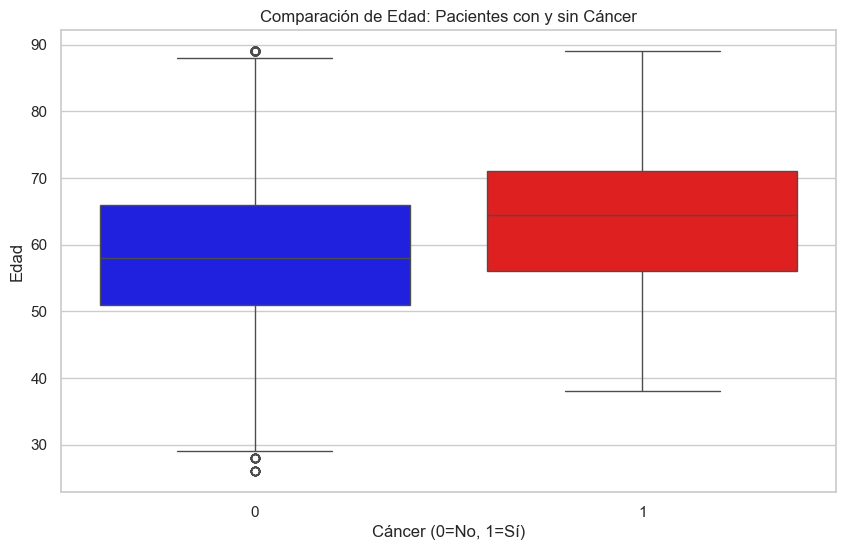

In [49]:
# Filtrar los pacientes con c√°ncer y sin c√°ncer
cancer_patients = train_df[train_df['cancer'] == 1]
no_cancer_patients = train_df[train_df['cancer'] == 0]

# Configurar estilo visual
sns.set(style="whitegrid")

# Boxplot para comparar las distribuciones de edad
plt.figure(figsize=(10, 6))
sns.boxplot(x='cancer', y='age', data=train_df, palette=['blue', 'red'])
plt.title('Comparaci√≥n de Edad: Pacientes con y sin C√°ncer')
plt.xlabel('C√°ncer (0=No, 1=S√≠)')
plt.ylabel('Edad')
plt.show()

**Pacientes sin c√°ncer (C√°ncer = 0, barra azul):**

* Rango intercuart√≠lico (IQR): La mayor√≠a de los pacientes tienen edades entre aproximadamente 52 y 65 a√±os.
* Mediana: Alrededor de los 58 a√±os.
* Rango completo: Los pacientes sin c√°ncer tienen edades que van desde los 30 hasta los 89 a√±os, con algunos outliers menores por debajo de los 40 a√±os.

**Pacientes con c√°ncer (C√°ncer = 1, barra roja):**

* Rango intercuart√≠lico (IQR): La mayor√≠a de los pacientes tienen edades entre aproximadamente 60 y 70 a√±os.
* Mediana: Alrededor de los 65 a√±os, notablemente mayor que para los pacientes sin c√°ncer.
* Rango completo: Los pacientes con c√°ncer tambi√©n tienen edades entre 30 y 89 a√±os, pero con un rango ligeramente desplazado hacia valores m√°s altos.

* Existe una clara diferencia en la distribuci√≥n de edad entre los dos grupos, con los pacientes con c√°ncer tendiendo a ser mayores.
* Esto es consistente con el conocimiento m√©dico: el riesgo de c√°ncer generalmente aumenta con la edad debido a factores acumulativos como mutaciones celulares y cambios hormonales.
* La variable age puede ser un predictor √∫til para modelos de clasificaci√≥n, ya que muestra diferencias notables entre los dos grupos.

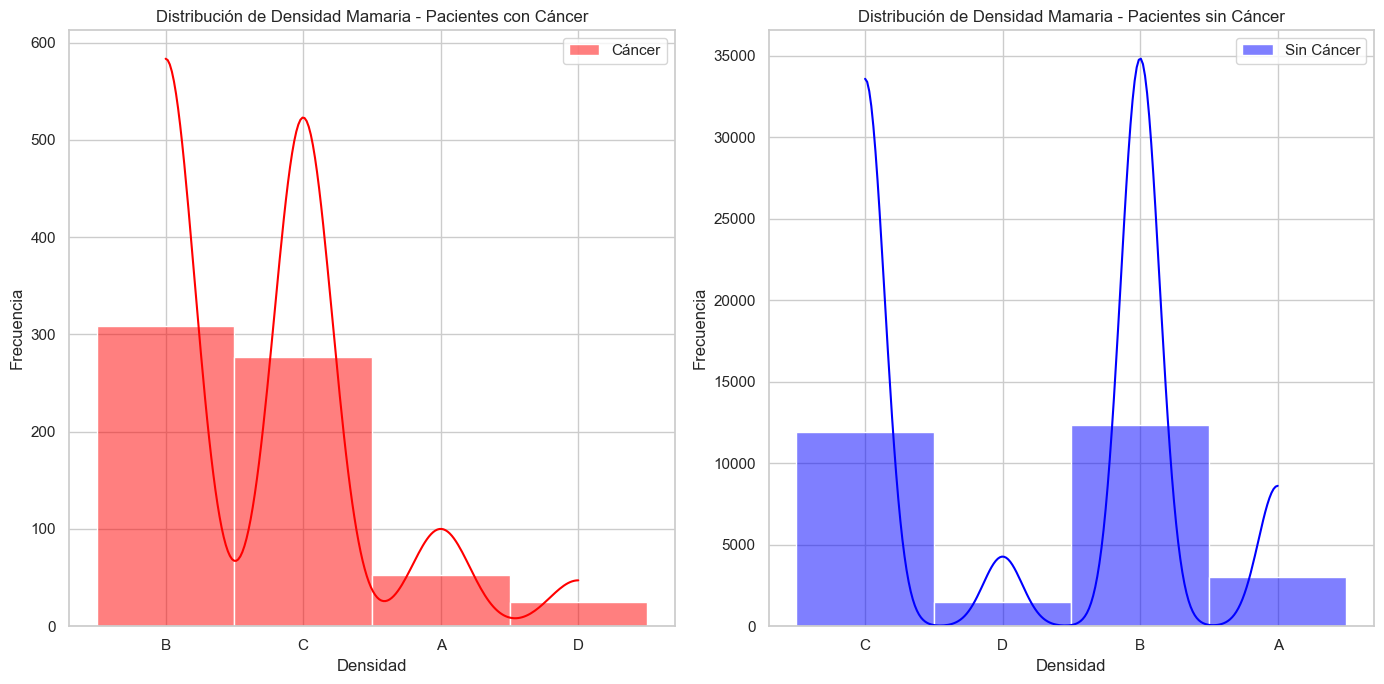

In [50]:
# Histograma para visualizar la distribuci√≥n de la densidad
plt.figure(figsize=(14, 7))

# Densidad en pacientes con c√°ncer
plt.subplot(1, 2, 1)
sns.histplot(cancer_patients['density'], kde=True, bins=20, color='red', label='C√°ncer')
plt.title('Distribuci√≥n de Densidad Mamaria - Pacientes con C√°ncer')
plt.xlabel('Densidad')
plt.ylabel('Frecuencia')
plt.legend()

# Densidad en pacientes sin c√°ncer
plt.subplot(1, 2, 2)
sns.histplot(no_cancer_patients['density'], kde=True, bins=20, color='blue', label='Sin C√°ncer')
plt.title('Distribuci√≥n de Densidad Mamaria - Pacientes sin C√°ncer')
plt.xlabel('Densidad')
plt.ylabel('Frecuencia')
plt.legend()

plt.tight_layout()
plt.show()

**Pacientes con c√°ncer (gr√°fico izquierdo, color rojo):**

+ Densidad B: Es la m√°s prevalente en este grupo, con una frecuencia alta.
+ Densidad C: Tambi√©n es com√∫n, aunque en menor proporci√≥n que la densidad B.
+ Densidades A y D: Tienen una representaci√≥n mucho menor, siendo la densidad D la menos com√∫n.

**Pacientes sin c√°ncer (gr√°fico derecho, color azul):**

+ Densidad B y C: Ambas tienen una representaci√≥n notable, pero la densidad C es m√°s prevalente en este grupo, a diferencia de los pacientes con c√°ncer.
+ Densidades A y D: Siguen siendo menos frecuentes, pero la densidad A es ligeramente m√°s com√∫n aqu√≠ que en los pacientes con c√°ncer.

Densidad B:
- M√°s prevalente entre pacientes con c√°ncer, lo que podr√≠a sugerir una relaci√≥n entre esta densidad y el diagn√≥stico de c√°ncer.

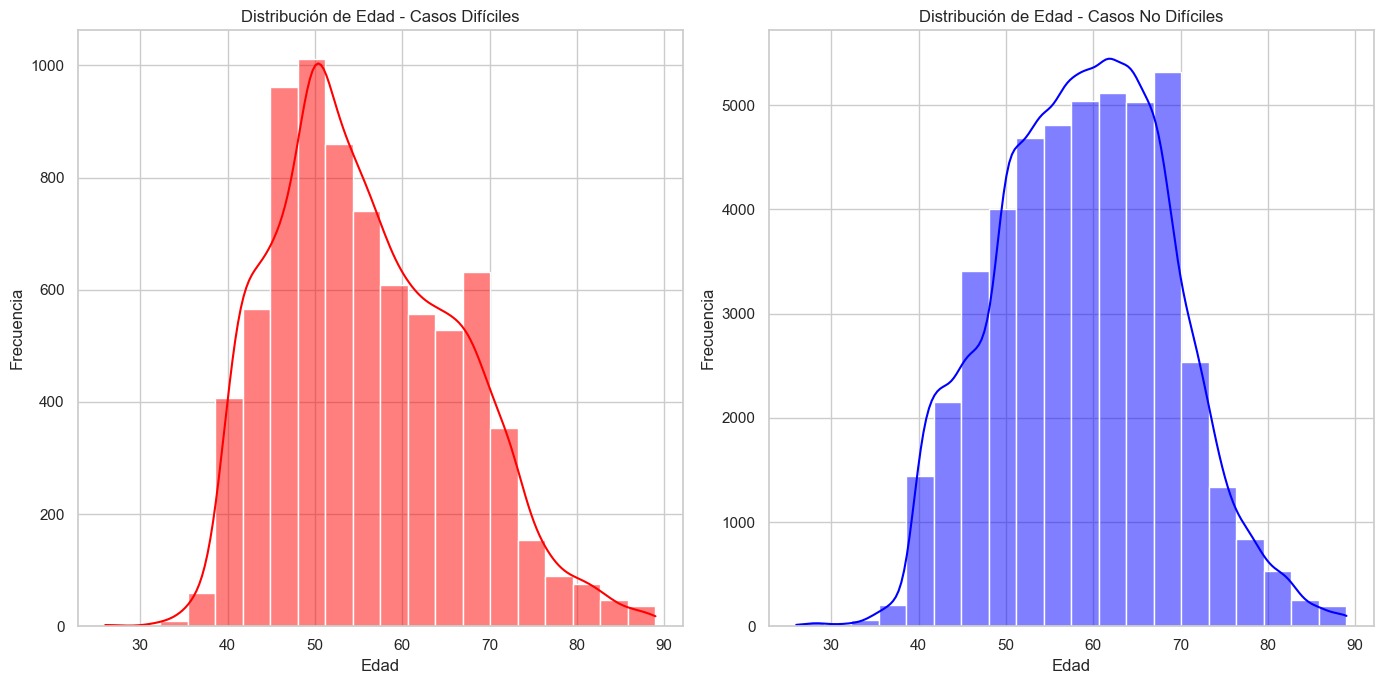

C:\Users\Melissa\AppData\Local\Temp\ipykernel_57704\825165943.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=difficult_cases, x='view', palette='Reds')
C:\Users\Melissa\AppData\Local\Temp\ipykernel_57704\825165943.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=non_difficult_cases, x='view', palette='Blues')


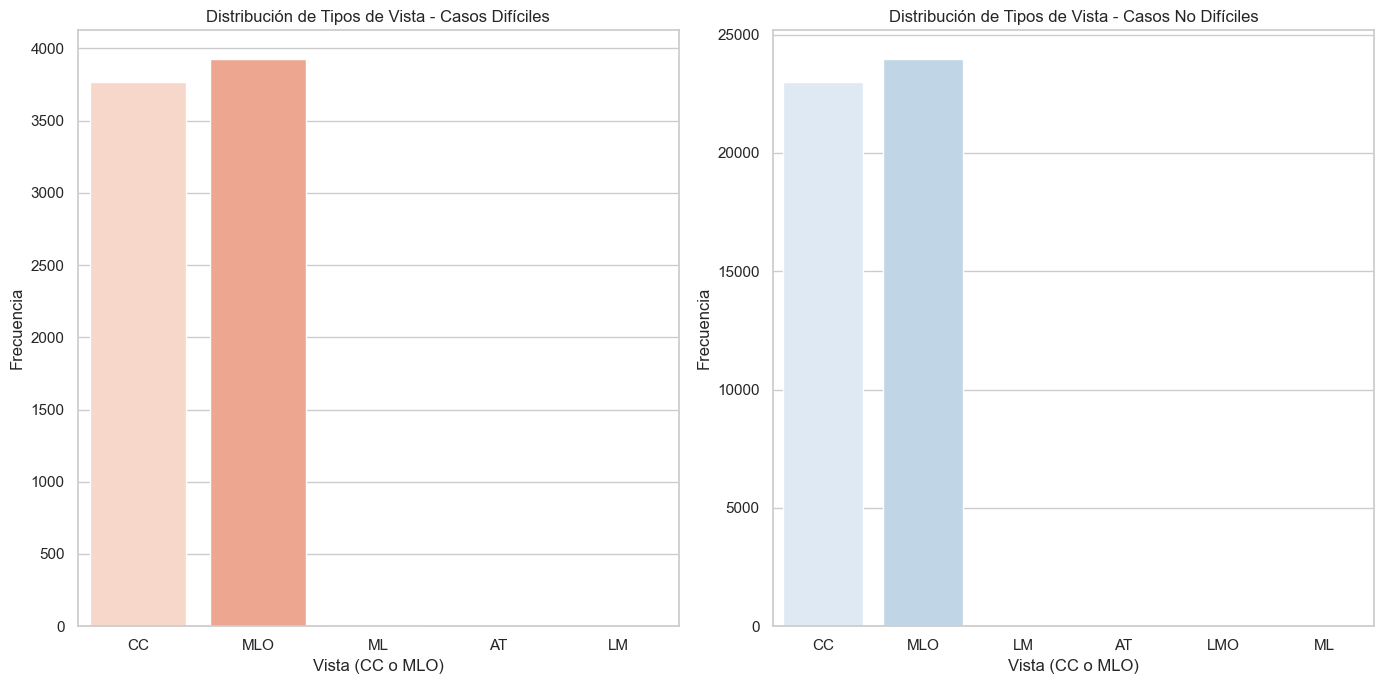

In [51]:
# Filtrar casos dif√≠ciles y no dif√≠ciles
difficult_cases = train_df[train_df['difficult_negative_case'] == True]
non_difficult_cases = train_df[train_df['difficult_negative_case'] == False]

# Configurar estilo visual
sns.set(style="whitegrid")

# Comparar la edad en casos dif√≠ciles y no dif√≠ciles
plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
sns.histplot(difficult_cases['age'], kde=True, bins=20, color='red', label='Dif√≠cil')
plt.title('Distribuci√≥n de Edad - Casos Dif√≠ciles')
plt.xlabel('Edad')
plt.ylabel('Frecuencia')

plt.subplot(1, 2, 2)
sns.histplot(non_difficult_cases['age'], kde=True, bins=20, color='blue', label='No Dif√≠cil')
plt.title('Distribuci√≥n de Edad - Casos No Dif√≠ciles')
plt.xlabel('Edad')
plt.ylabel('Frecuencia')

plt.tight_layout()
plt.show()

# Comparar el tipo de vista en casos dif√≠ciles y no dif√≠ciles
plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
sns.countplot(data=difficult_cases, x='view', palette='Reds')
plt.title('Distribuci√≥n de Tipos de Vista - Casos Dif√≠ciles')
plt.xlabel('Vista (CC o MLO)')
plt.ylabel('Frecuencia')

plt.subplot(1, 2, 2)
sns.countplot(data=non_difficult_cases, x='view', palette='Blues')
plt.title('Distribuci√≥n de Tipos de Vista - Casos No Dif√≠ciles')
plt.xlabel('Vista (CC o MLO)')
plt.ylabel('Frecuencia')

plt.tight_layout()
plt.show()

**Casos dif√≠ciles (gr√°fico izquierdo):**

- Distribuci√≥n:
    - Tiene un pico (moda) alrededor de los 50 a√±os.
    - Hay una concentraci√≥n considerable entre los 45 y 55 a√±os, con un declive gradual hacia edades mayores y menores.
- Rango de edad:
    - La mayor√≠a de los casos se encuentran entre 40 y 70 a√±os.
    - Los casos dif√≠ciles son menos comunes en edades menores a 40 y mayores a 75 a√±os.

**Casos no dif√≠ciles(gr√°fico derecho):**

- Distribuci√≥n:
    - Tiene un pico (moda) alrededor de los 65 a√±os, mostrando un desplazamiento hacia edades mayores en comparaci√≥n con los casos dif√≠ciles.
    - Hay una distribuci√≥n m√°s amplia en el rango de edad entre 50 y 70 a√±os, lo que sugiere que los casos no dif√≠ciles abarcan una poblaci√≥n m√°s diversa en t√©rminos de edad.
- Rango de edad:
    - La mayor√≠a de los casos se concentran entre los 50 y 75 a√±os, con una representaci√≥n m√°s notable en edades mayores (70+).

**Casos dif√≠ciles (izquierda, color rojo):**

- Proyecciones CC (Cranio-Caudal):
    - Frecuencia ligeramente menor que MLO.
    - Representa alrededor del 48% de las vistas en los casos dif√≠ciles.
- Proyecciones MLO (Medio-Lateral Oblicua):
    - Es la m√°s com√∫n entre los casos dif√≠ciles, con una ligera ventaja sobre CC.
    - Representa aproximadamente el 52% de las vistas.
- Otras vistas (ML, AT, LM, LMO):
    - No tienen representaci√≥n en los casos dif√≠ciles, lo que implica que estas vistas no se utilizan o no est√°n presentes en este conjunto para estos casos.

**Casos no dif√≠ciles (derecha, color azul):**

- Proyecciones CC:
    - Similar a los casos dif√≠ciles, CC representa una proporci√≥n significativa pero ligeramente menor que MLO.
- Proyecciones MLO:
    - Es la vista m√°s frecuente, representando un porcentaje mayor en comparaci√≥n con CC.
- Otras vistas (ML, AT, LM, LMO):
    - Estas vistas tampoco est√°n presentes en los casos no dif√≠ciles.

- La mayor√≠a de las mamograf√≠as en este conjunto de datos utilizan vistas est√°ndar (CC y MLO). Esto es consistente con la pr√°ctica cl√≠nica, donde estas vistas son las m√°s comunes para evaluar el tejido mamario.
- La vista MLO es la m√°s frecuente en ambos grupos (casos dif√≠ciles y no dif√≠ciles). Esto podr√≠a deberse a que proporciona una mejor visualizaci√≥n de la parte superior y lateral del tejido mamario, lo cual es importante tanto para evaluaciones rutinarias como para casos complejos.
- La distribuci√≥n entre CC y MLO es muy similar para ambos grupos, lo que indica que la dificultad del caso no parece estar relacionada con el tipo de vista utilizada.

## Reducci√≥n del conjunto de datos y balanceo de clases

In [52]:
minority_class_size = train_df['cancer'].value_counts().min()

# Definir la proporci√≥n de muestras de la clase mayoritaria (ejemplo: 2 veces la clase minoritaria)
majority_class_multiplier = 10
majority_class_size = minority_class_size * majority_class_multiplier

# Obtener todas las muestras de la clase minoritaria
minority_samples = train_df[train_df['cancer'] == 1]

# Obtener una muestra aleatoria de la clase mayoritaria
majority_samples = train_df[train_df['cancer'] == 0].sample(majority_class_size, random_state=42)

# Combinar las muestras de ambas clases
balanced_df = pd.concat([minority_samples, majority_samples]).sample(frac=1, random_state=42).reset_index(drop=True)

# Verificar el balance de clases
print(balanced_df['cancer'].value_counts())

cancer
0    11580
1     1158
Name: count, dtype: int64


El conjunto de datos inicial era muy grande, lo que pod√≠a generar problemas de rendimiento en el entrenamiento del modelo (como mayor tiempo de procesamiento o uso excesivo de recursos). Adem√°s, la variable objetivo (cancer) estaba desbalanceada, con una cantidad mucho mayor de muestras de la clase 0 (sin c√°ncer) frente a la clase 1 (con c√°ncer). Para solucionar esto:

1. Se calcula el tama√±o de la clase minoritaria (minority_class_size) para establecer un punto de referencia.
2. Se incluye 10 veces m√°s muestras de la clase mayoritaria (cancer = 0) que de la clase minoritaria (cancer = 1), ajustando el tama√±o total del conjunto.
3. Se extraen todas las muestras de la clase minoritaria (minority_samples).
4. Se toma una muestra aleatoria de la clase mayoritaria (majority_samples) de tama√±o proporcional a la clase minoritaria, utilizando un generador de n√∫meros aleatorios para garantizar reproducibilidad (random_state=42).
5. Se unen las muestras seleccionadas de ambas clases para crear un nuevo conjunto de datos balanceado y reducido.
6. Se reordenan las muestras aleatoriamente para evitar patrones espec√≠ficos en el orden de las filas.

## Histograma de Color por Clase

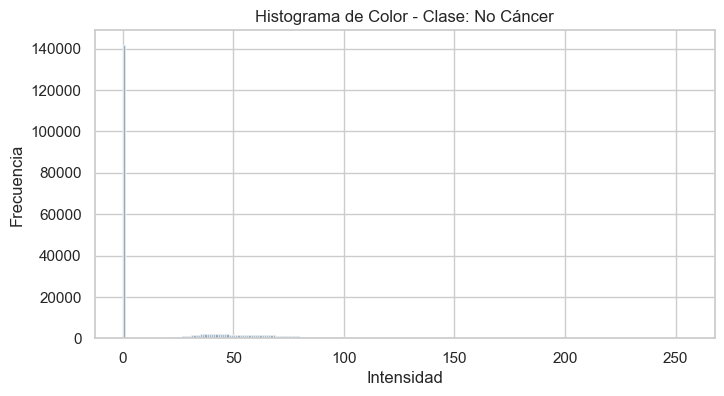

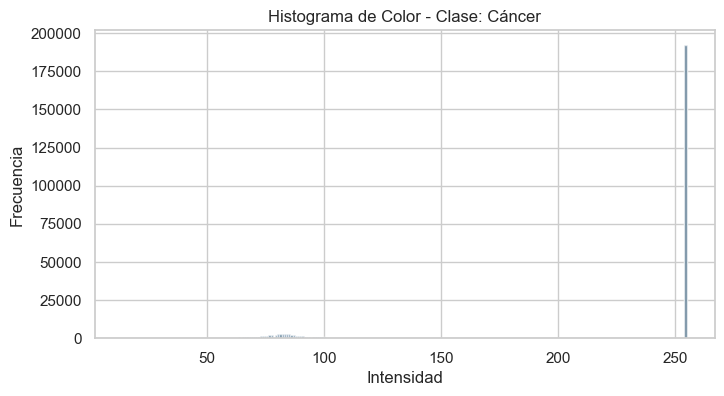

In [53]:
def plot_color_histogram_per_class(df, img_col='img_path', label_col='cancer_str'):
    for label in df[label_col].unique():
        subset = df[df[label_col] == label]
        img = cv2.imread(subset.iloc[0][img_col])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        chans = cv2.split(img)
        colors = ("r", "g", "b")
        plt.figure(figsize=(8, 4))
        plt.title(f"Histograma de Color - Clase: {label}")
        for chan, color in zip(chans, colors):
            plt.hist(chan.ravel(), bins=256, color=color, alpha=0.5)
        plt.xlabel("Intensidad")
        plt.ylabel("Frecuencia")
        plt.show()

balanced_df['cancer_str'] = balanced_df['cancer'].map({0: 'No C√°ncer', 1: 'C√°ncer'})
plot_color_histogram_per_class(balanced_df)


**Histograma de Intensidades - Clase: No C√°ncer**
Pico muy pronunciado cerca de 0:
* Las im√°genes de mamograf√≠as sin c√°ncer tienen la mayor√≠a de sus p√≠xeles en valores muy oscuros, es decir, casi negros.
* Esto sugiere ausencia de estructuras densas (como masas o calcificaciones), y predominio de tejido mamario homog√©neo o √°reas de fondo.
* Pocos valores en intensidades medias o altas:
    * La curva cae r√°pidamente despu√©s del pico inicial, lo que indica que hay muy pocas zonas brillantes en las im√°genes.

Por lo que se puede concluir que: Las im√°genes sin c√°ncer son en su mayor√≠a oscuras, con un histograma sesgado fuertemente hacia la izquierda (intensidades bajas), lo que refleja una baja densidad radiol√≥gica y ausencia de lesiones relevantes.

**Histograma de Intensidades - Clase: C√°ncer**
* Pico fuerte en intensidades altas (~255):
* Las im√°genes con c√°ncer muestran un pico en el extremo derecho del histograma, indicando la presencia de √°reas muy brillantes.
* Estas zonas suelen corresponder a calcificaciones, masas densas o bordes an√≥malos que reflejan m√°s radiaci√≥n y aparecen m√°s blancas.
* Distribuci√≥n asim√©trica inversa a la clase No C√°ncer:
    * La imagen tiene muchas regiones brillantes (intensidad alta) y mucho menos contenido oscuro.

Por lo que las im√°genes con c√°ncer est√°n dominadas por zonas brillantes, lo que indica mayor densidad radiol√≥gica asociada a lesiones sospechosas. El histograma est√° sesgado hacia intensidades altas, a diferencia de la clase No C√°ncer.

## Imagenes por clase

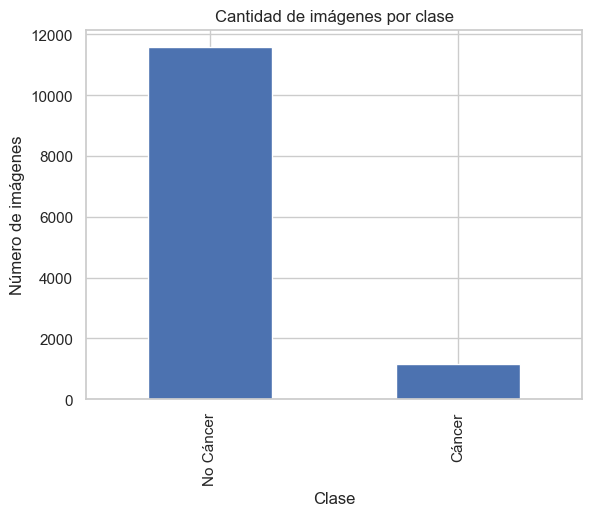

In [54]:
balanced_df['cancer_str'].value_counts().plot(kind='bar', title="Cantidad de im√°genes por clase")
plt.xlabel("Clase")
plt.ylabel("N√∫mero de im√°genes")
plt.show()

## Histograma de color de objetos segmentados

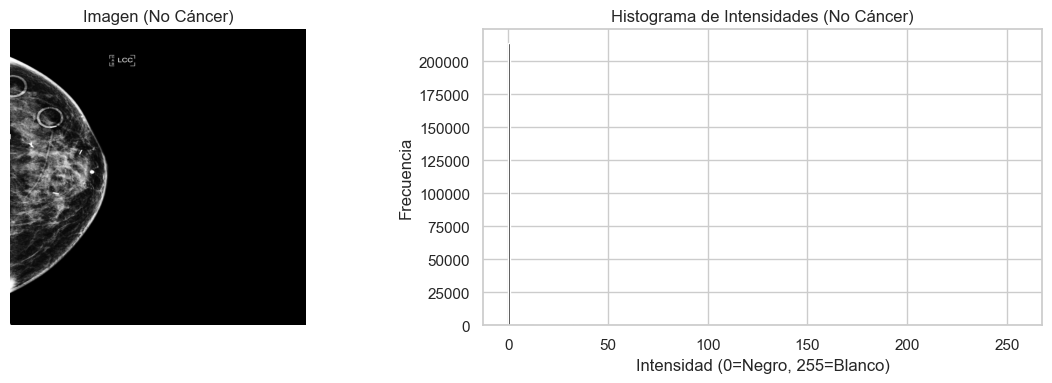

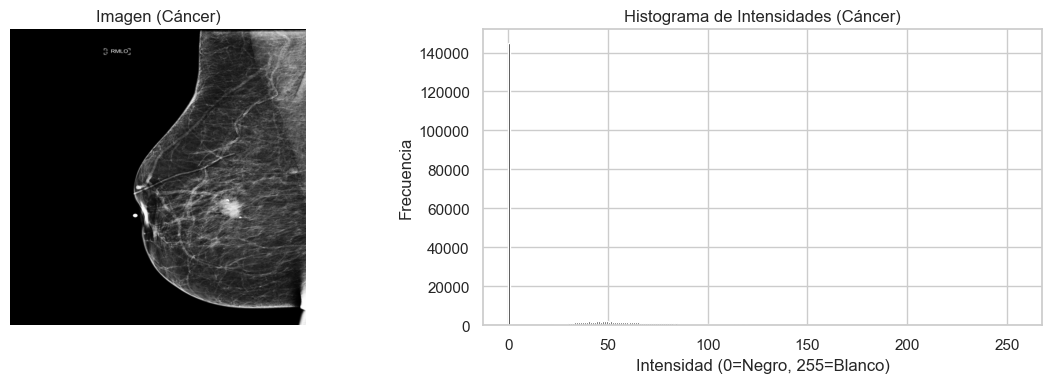

In [55]:
def plot_single_image_histograms(df, img_col='img_path', label_col='cancer_str'):
    classes = df[label_col].unique()
    
    for clase in classes:
        path = df[df[label_col] == clase].sample(1, random_state=2)[img_col].values[0]
        img = cv2.imread(path)
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        plt.figure(figsize=(12, 4))

        # Imagen original
        plt.subplot(1, 2, 1)
        plt.imshow(img_gray, cmap='gray')
        plt.title(f"Imagen ({clase})")
        plt.axis("off")

        # Histograma
        plt.subplot(1, 2, 2)
        plt.hist(img_gray.ravel(), bins=256, color='black')
        plt.title(f"Histograma de Intensidades ({clase})")
        plt.xlabel("Intensidad (0=Negro, 255=Blanco)")
        plt.ylabel("Frecuencia")

        plt.tight_layout()
        plt.show()

plot_single_image_histograms(balanced_df)



**Interpretaci√≥n del histograma de intensidades por clase**

**Imagen: No C√°ncer**

**Observaci√≥n visual:**
- La imagen muestra una mamograf√≠a con predominio de fondo negro y tejido mamario con baja densidad.
- Se observan algunas marcas circulares t√≠picas, pero no hay presencia de masas o zonas muy brillantes.

**Histograma:**
- El histograma tiene un pico muy pronunciado en intensidades cercanas a 0, lo cual indica que la mayor parte de la imagen corresponde a zonas oscuras (fondo).
- Existe muy poca frecuencia en intensidades medias o altas, lo cual sugiere que el tejido mamario es homog√©neo y no contiene estructuras densas.

**Conclusi√≥n:**
- Las mamograf√≠as sin c√°ncer suelen estar dominadas por intensidades bajas, asociadas a la ausencia de lesiones. Esta distribuci√≥n es esperable en im√°genes de tejido sano.

---

**Imagen: C√°ncer**

**Observaci√≥n visual:**
- Se observa una lesi√≥n densa y brillante en el centro de la mama, destac√°ndose claramente del tejido circundante.
- El contraste general en la imagen es mayor comparado con la imagen sin c√°ncer.

**Histograma:**
- Aunque tambi√©n existe un pico en intensidades bajas, se observa una mayor dispersi√≥n hacia valores altos (cercanos a 255).
- Esto indica que hay presencia significativa de p√≠xeles brillantes, correspondientes a la regi√≥n tumoral visible en la imagen.

**Conclusi√≥n:**
- Las mamograf√≠as con c√°ncer presentan mayor cantidad de intensidades altas, lo cual refleja la presencia de anomal√≠as densas como masas o calcificaciones.

##  Distribuci√≥n de tama√±os de imagen


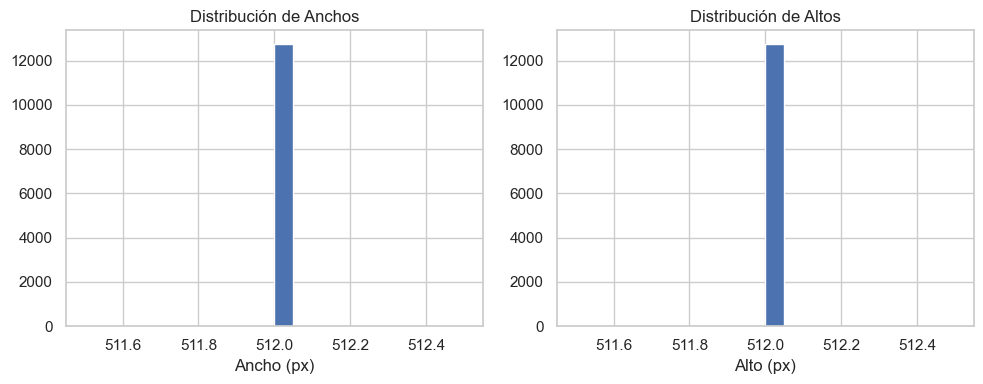

In [56]:
def image_size_distribution(df, img_col='img_path'):
    sizes = df[img_col].apply(lambda p: Image.open(p).size)  # (ancho, alto)
    widths, heights = zip(*sizes)
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.hist(widths, bins=20)
    plt.title("Distribuci√≥n de Anchos")
    plt.xlabel("Ancho (px)")
    plt.subplot(1, 2, 2)
    plt.hist(heights, bins=20)
    plt.title("Distribuci√≥n de Altos")
    plt.xlabel("Alto (px)")
    plt.tight_layout()
    plt.show()

image_size_distribution(balanced_df)


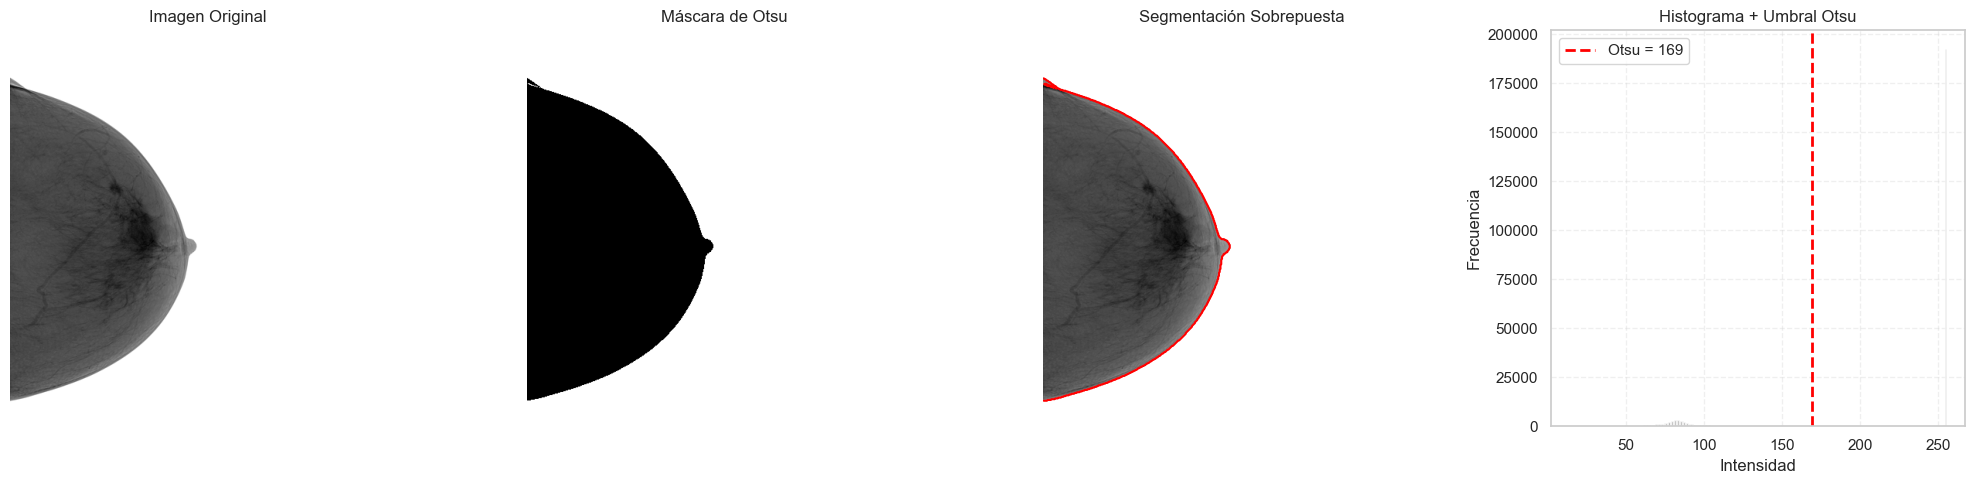

In [57]:
def analisis_completo_con_otsu(path):
    # Leer imagen en escala de grises
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)

    # Calcular umbral de Otsu
    otsu_thresh = threshold_otsu(img)

    # Generar m√°scara
    mask = img > otsu_thresh

    # Contornos de la m√°scara
    contours = measure.find_contours(mask, 0.5)

    # Crear figura con 4 subplots
    fig, axs = plt.subplots(1, 4, figsize=(20, 5))

    # Imagen original
    axs[0].imshow(img, cmap='gray')
    axs[0].set_title('Imagen Original')
    axs[0].axis('off')

    # M√°scara binaria
    axs[1].imshow(mask, cmap='gray')
    axs[1].set_title('M√°scara de Otsu')
    axs[1].axis('off')

    # Segmentaci√≥n sobrepuesta
    axs[2].imshow(img, cmap='gray')
    for contour in contours:
        axs[2].plot(contour[:, 1], contour[:, 0], linewidth=1.5, color='red')
    axs[2].set_title('Segmentaci√≥n Sobrepuesta')
    axs[2].axis('off')

    # Histograma con l√≠nea de Otsu
    axs[3].hist(img.ravel(), bins=256, color='gray', alpha=0.7)
    axs[3].axvline(otsu_thresh, color='red', linestyle='--', linewidth=2, label=f'Otsu = {otsu_thresh:.0f}')
    axs[3].set_title('Histograma + Umbral Otsu')
    axs[3].set_xlabel('Intensidad')
    axs[3].set_ylabel('Frecuencia')
    axs[3].legend()
    axs[3].grid(True, linestyle='--', alpha=0.3)

    plt.tight_layout()
    plt.show()

# Imagen con cancer
img_path = balanced_df[balanced_df['cancer'] == 1].iloc[0]['img_path']
analisis_completo_con_otsu(img_path)



**Segmentaci√≥n de imagen con c√°ncer usando el m√©todo de Otsu**

Se presenta una imagen mamogr√°fica correspondiente a un caso con diagn√≥stico de c√°ncer. La imagen fue analizada mediante el umbral autom√°tico de Otsu para segmentar el √°rea de inter√©s (tejido mamario).

**Panel 1: Imagen original**
La imagen muestra una mamograf√≠a en escala de grises con estructuras glandulares visibles. Se observa una zona m√°s densa en el centro, la cual podr√≠a corresponder a una masa tumoral. El contraste general de la imagen es alto.

**Panel 2: M√°scara de Otsu**
Aplicando el m√©todo de Otsu se obtiene una m√°scara binaria que separa el tejido mamario (blanco) del fondo (negro). El algoritmo seleccion√≥ autom√°ticamente un umbral de intensidad de **169**, valor relativamente alto, lo cual sugiere la presencia de regiones brillantes en la imagen.

**Panel 3: Segmentaci√≥n sobrepuesta**
La segmentaci√≥n obtenida se superpone a la imagen original con un contorno rojo. Se observa que la m√°scara delimita correctamente el contorno de la mama, capturando gran parte del tejido relevante.

**Panel 4: Histograma de intensidades**
El histograma muestra la distribuci√≥n de intensidades en la imagen. El umbral de Otsu (169) est√° indicado por una l√≠nea punteada roja. La mayor√≠a de los p√≠xeles est√°n concentrados por debajo de este umbral, mientras que las intensidades superiores (asociadas a lesiones) ocupan una fracci√≥n menor, pero significativa.

**Conclusi√≥n:**
El valor alto del umbral de Otsu y la forma de la segmentaci√≥n son coherentes con la presencia de un √°rea densa en la imagen. Este an√°lisis respalda la utilidad del umbral Otsu y del √°rea segmentada como variables explicativas para modelos de predicci√≥n del c√°ncer de mama.


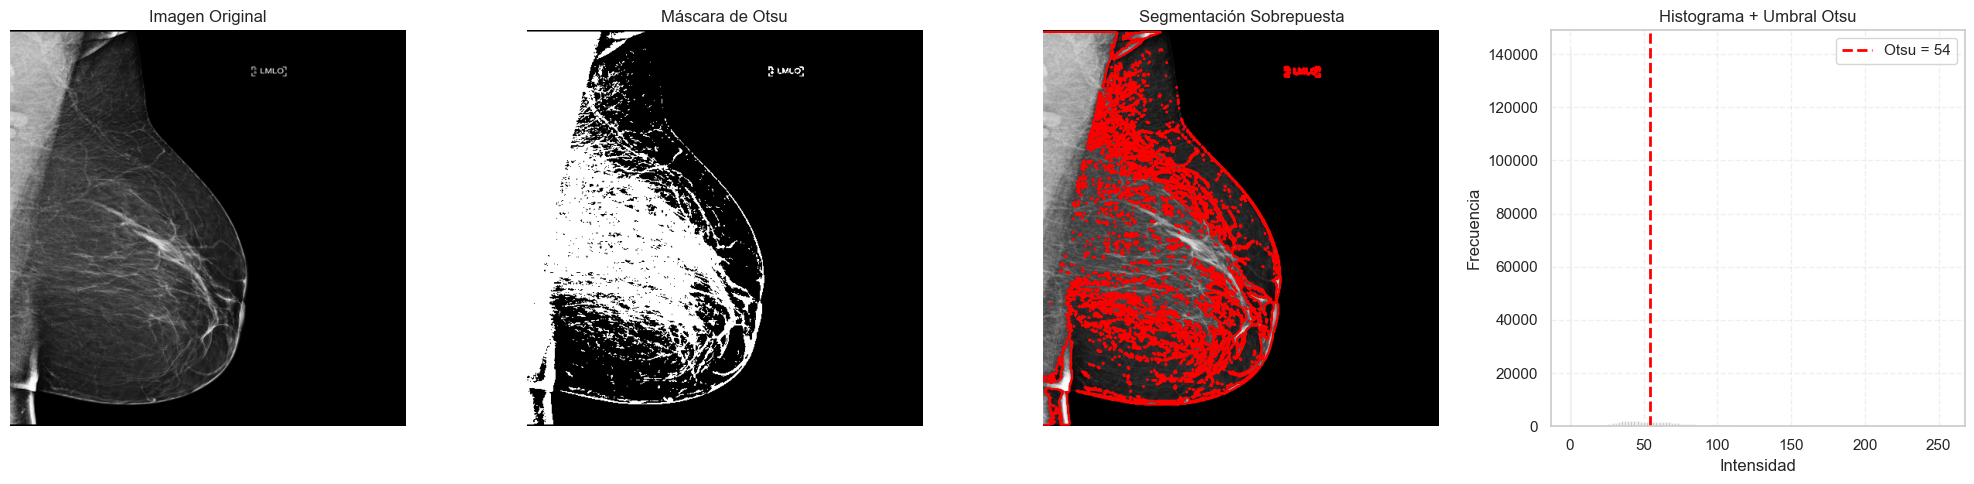

In [58]:
img_path = balanced_df[balanced_df['cancer'] == 0].iloc[0]['img_path'] # imagen sin cancer
analisis_completo_con_otsu(img_path)

Se presenta una mamograf√≠a correspondiente a un caso **sin diagn√≥stico de c√°ncer**. Se aplica el m√©todo de Otsu para segmentar el tejido mamario, con el objetivo de observar diferencias estructurales frente a los casos con c√°ncer.

**Panel 1: Imagen original**
La imagen muestra una mamograf√≠a en escala de grises con distribuci√≥n homog√©nea del tejido. No se observan regiones particularmente brillantes ni formaciones nodulares destacadas.

**Panel 2: M√°scara de Otsu**
La m√°scara generada por el algoritmo de Otsu presenta una segmentaci√≥n m√°s dispersa, con muchas peque√±as regiones brillantes dentro del tejido mamario. El umbral calculado fue de **54**, significativamente menor que en los casos con c√°ncer. Esto sugiere que la mayor√≠a de los p√≠xeles relevantes se encuentran en zonas menos brillantes (intensidades bajas).

**Panel 3: Segmentaci√≥n sobrepuesta**
El contorno generado por la m√°scara se superpone en rojo sobre la imagen original. La segmentaci√≥n cubre estructuras internas sin destacar √°reas densas centrales, como en los casos con c√°ncer. La segmentaci√≥n es m√°s difusa y refleja la falta de masas hiperintensas.

**Panel 4: Histograma de intensidades**
El histograma muestra una fuerte concentraci√≥n de intensidades en valores bajos (cercanos a 0), lo que coincide con el umbral bajo de Otsu. Esto es consistente con una imagen donde predominan los tejidos blandos sin anomal√≠as densas.

**Conclusi√≥n:**
El umbral bajo y la segmentaci√≥n dispersa obtenida con Otsu son indicativos de una mamograf√≠a sin √°reas sospechosas. Estos resultados refuerzan el valor del umbral de Otsu y la forma de la segmentaci√≥n como posibles descriptores para distinguir im√°genes normales de aquellas con signos de c√°ncer.


In [59]:
# Crear lista de resultados
otsu_data = []

# Iterar sobre todas las im√°genes
for _, row in tqdm(balanced_df.iterrows(), total=len(balanced_df)):
    img_path = row['img_path']
    label = row['cancer_str']  # 'C√°ncer' o 'No C√°ncer'

    try:
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            thresh = threshold_otsu(img)
            otsu_data.append({'img_path': img_path, 'cancer_str': label, 'otsu_threshold': thresh})
    except Exception as e:
        print(f"‚ö†Ô∏è Error con {img_path}: {e}")

# Convertir a DataFrame
otsu_df = pd.DataFrame(otsu_data)


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 12738/12738 [00:50<00:00, 252.90it/s]


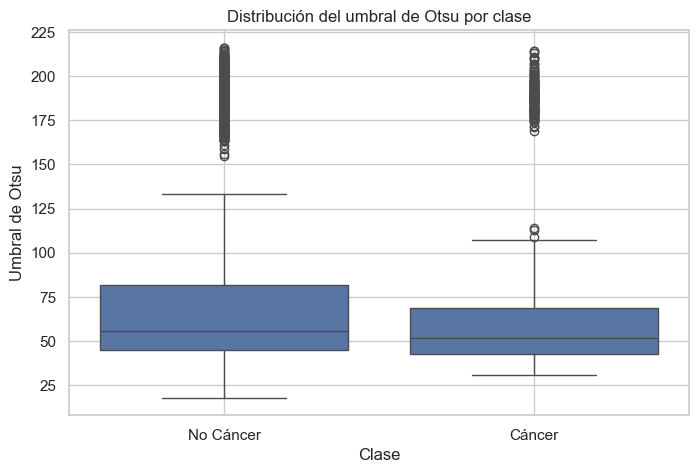

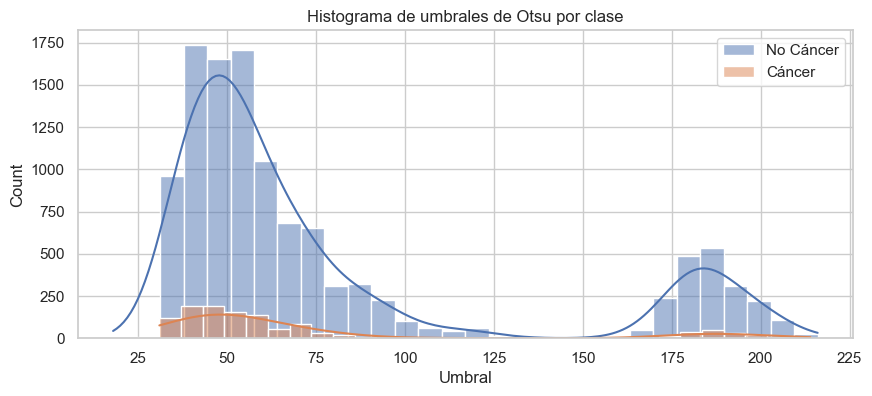

In [60]:
# Boxplot
plt.figure(figsize=(8, 5))
sns.boxplot(data=otsu_df, x='cancer_str', y='otsu_threshold')
plt.title('Distribuci√≥n del umbral de Otsu por clase')
plt.ylabel('Umbral de Otsu')
plt.xlabel('Clase')
plt.grid(True)
plt.show()

# Histograma
plt.figure(figsize=(10, 4))
for clase in otsu_df['cancer_str'].unique():
    sns.histplot(otsu_df[otsu_df['cancer_str'] == clase]['otsu_threshold'], label=clase, kde=True, bins=30)
plt.title('Histograma de umbrales de Otsu por clase')
plt.xlabel('Umbral')
plt.legend()
plt.show()


**An√°lisis de distribuci√≥n del umbral de Otsu por clase**

Para cada mamograf√≠a del dataset, se calcul√≥ el umbral de Otsu de forma individual con el objetivo de explorar su comportamiento como posible descriptor diagn√≥stico.

**Gr√°fico 1: Diagrama de caja (Boxplot)**
El diagrama de caja muestra la distribuci√≥n del valor de umbral de Otsu en dos grupos: **No C√°ncer** y **C√°ncer**.

- El grupo **No C√°ncer** presenta una mayor dispersi√≥n, con presencia de valores extremos (outliers) elevados.
- El grupo **C√°ncer** muestra una distribuci√≥n m√°s concentrada y con una mediana levemente inferior.
- A pesar de la superposici√≥n entre ambos grupos, se observan diferencias que sugieren una tendencia diagn√≥stica: **umbrales m√°s bajos suelen asociarse a presencia de c√°ncer**, lo que coincide con la mayor densidad local de regiones brillantes (lesiones).

 **Gr√°fico 2: Histograma de umbrales por clase**
Este histograma con densidad suavizada permite observar de forma m√°s detallada la forma de las distribuciones:

- En **No C√°ncer**, se observa una distribuci√≥n bimodal: una gran concentraci√≥n entre 40‚Äì80, y otra secundaria alrededor de 180‚Äì200.
- En **C√°ncer**, la distribuci√≥n se concentra entre 40‚Äì70, sin presencia significativa en valores altos.
- Esto sugiere que los **umbrales de Otsu elevados son m√°s caracter√≠sticos de im√°genes normales**, mientras que **valores m√°s bajos son comunes en im√°genes con c√°ncer**.

 **Conclusi√≥n:**
El an√°lisis global muestra que el umbral de Otsu, aunque no separa perfectamente las clases, presenta patrones diferenciales en su distribuci√≥n que pueden ser aprovechados como una **variable auxiliar** dentro del modelo que usaremos mas adelante


In [61]:
print("Resumen estad√≠stico por clase:")
print(otsu_df.groupby('cancer_str')['otsu_threshold'].describe())

Resumen estad√≠stico por clase:
              count       mean        std   min   25%   50%   75%    max
cancer_str                                                              
C√°ncer       1158.0  71.056995  49.010769  31.0  43.0  52.0  69.0  214.0
No C√°ncer   11580.0  78.373316  51.606767  18.0  45.0  56.0  82.0  216.0


- **La media del umbral de Otsu es menor en im√°genes con c√°ncer** (71.06) comparado con im√°genes sin c√°ncer (78.37), lo cual indica que las im√°genes cancer√≠genas tienden a contener **m√°s regiones brillantes** que influyen en el umbral autom√°tico.
- **La mediana** tambi√©n es menor en im√°genes con c√°ncer (52 vs. 56), reforzando la tendencia general.
- **El rango completo** es similar en ambas clases, pero **los valores extremos altos** (75¬∞ percentil y m√°ximo) son m√°s frecuentes en im√°genes normales.

In [62]:
balanced_df = balanced_df.merge(otsu_df[['img_path', 'otsu_threshold']], on='img_path', how='left')

**Calculo del area segmentada por otsu**

Area segmentada por Otsu: Es la cantidad de p√≠xeles que superan el umbral de Otsu en una imagen ‚Äî es decir, donde img > otsu_threshold. Esto equivale a contar los p√≠xeles blancos en la m√°scara binaria generada por Otsu. Pixeles clasificados como brillantes

In [63]:
# Lista para almacenar los resultados
area_data = []

# Iterar sobre todas las im√°genes
for _, row in tqdm(balanced_df.iterrows(), total=len(balanced_df)):
    img_path = row['img_path']
    
    try:
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            thresh = threshold_otsu(img)
            mask = img > thresh
            area = mask.sum()  # n√∫mero de p√≠xeles donde la m√°scara es True (1)
            area_data.append({'img_path': img_path, 'area_segmentada_px': area})
    except Exception as e:
        print(f" Error con {img_path}: {e}")

# Convertir a DataFrame
area_df = pd.DataFrame(area_data)

# Hacer merge con balanced_df
balanced_df = balanced_df.merge(area_df, on='img_path', how='left')


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 12738/12738 [00:44<00:00, 286.08it/s]


In [64]:
print(balanced_df[['img_path', 'otsu_threshold', 'area_segmentada_px']].head())

                                            img_path  otsu_threshold  \
0  C:\Users\Melissa\Documents\Maestria Ciencia Da...              54   
1  C:\Users\Melissa\Documents\Maestria Ciencia Da...              37   
2  C:\Users\Melissa\Documents\Maestria Ciencia Da...             202   
3  C:\Users\Melissa\Documents\Maestria Ciencia Da...              34   
4  C:\Users\Melissa\Documents\Maestria Ciencia Da...              78   

   area_segmentada_px  
0               67485  
1               87360  
2              200305  
3               45736  
4               47221  


In [65]:
# Resumen general
resumen_area = balanced_df.groupby('cancer_str')['area_segmentada_px'].describe()
print("Resumen estad√≠stico del √°rea segmentada (en p√≠xeles) por clase:\n")
print(resumen_area)


Resumen estad√≠stico del √°rea segmentada (en p√≠xeles) por clase:

              count          mean           std      min       25%      50%  \
cancer_str                                                                    
C√°ncer       1158.0  90105.013817  49212.678707  13048.0  54582.75  77814.0   
No C√°ncer   11580.0  94797.347927  52588.828460   5159.0  55713.75  81319.0   

                  75%       max  
cancer_str                       
C√°ncer      111131.75  238668.0  
No C√°ncer   119006.25  246424.0  


- El √°rea segmentada promedio es **ligeramente mayor en im√°genes sin c√°ncer** (94,797 px) frente a las im√°genes con c√°ncer (90,105 px), aunque la diferencia **no es significativa** en t√©rminos absolutos.
- **La mediana y el rango intercuart√≠lico** tambi√©n muestran que las √°reas segmentadas tienden a ser mayores en la clase No C√°ncer.
- Esto puede explicarse por el hecho de que muchas im√°genes sin c√°ncer presentan **tejido mamario denso** que ocupa una gran parte de la imagen, mientras que en algunas im√°genes con c√°ncer, **la presencia de lesiones brillantes reduce la extensi√≥n segmentada por Otsu**.

In [66]:
balanced_df.columns

Index(['site_id', 'patient_id', 'image_id', 'laterality', 'view', 'age',
       'cancer', 'biopsy', 'invasive', 'BIRADS', 'implant', 'density',
       'machine_id', 'difficult_negative_case', 'img_path', 'cancer_str',
       'otsu_threshold', 'area_segmentada_px'],
      dtype='object')

In [128]:
data_modelo = balanced_df[['patient_id', 'image_id','age','biopsy', 'invasive', 'BIRADS', 'area_segmentada_px','otsu_threshold','cancer']].copy()

In [129]:
data_modelo.rename(columns={'cancer': 'label'}, inplace=True)

## **Visi√≥n por Computador Aplicada a Mamograf√≠as**

La visi√≥n por computador aplicada a mamograf√≠as busca automatizar y potenciar el an√°lisis de im√°genes m√©dicas mediante t√©cnicas avanzadas de procesamiento e interpretaci√≥n visual. En este contexto, se emplean modelos de redes neuronales convolucionales (CNN) para extraer patrones visuales que puedan estar asociados a la presencia de c√°ncer.

Como parte del pipeline, se implement√≥ una etapa de generaci√≥n de *heatmaps* usando Grad-CAM sobre un modelo preentrenado (VGG16). Esta t√©cnica permite **visualizar las regiones de la mamograf√≠a que activan con mayor fuerza al modelo**, facilitando la interpretaci√≥n y aumentando la transparencia del sistema. As√≠, se identifican autom√°ticamente zonas de inter√©s que podr√≠an corresponder a lesiones sospechosas, ayudando a complementar el juicio cl√≠nico.

El objetivo de este enfoque no es solo mejorar la calidad visual, sino tambi√©n **integrar interpretabilidad y localizaci√≥n espacial** dentro del modelo predictivo, alineando el an√°lisis automatizado con criterios m√©dicos relevantes.


In [130]:
# Cargar modelo una vez al inicio
model = VGG16(weights="imagenet")
grad_model = Model(inputs=model.inputs, outputs=[model.get_layer("block5_conv3").output, model.output])

In [131]:
# Funci√≥n para generar heatmap
def generate_heatmap(image_path):
    print("Generating heatmap")
    img = cv2.imread(image_path)
    img = cv2.resize(img, (224, 224))  # Ajustar tama√±o para el modelo
    img_array = np.expand_dims(img, axis=0)
    img_array = tf.keras.applications.vgg16.preprocess_input(img_array)

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        class_idx = tf.argmax(predictions[0])
        loss = predictions[:, class_idx]

    grads = tape.gradient(loss, conv_outputs)[0]
    weights = tf.reduce_mean(grads, axis=(0, 1))
    heatmap = tf.reduce_sum(weights * conv_outputs[0], axis=-1)

        # Normalizar heatmap
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    if not isinstance(heatmap, np.ndarray):  # Si no es un array de NumPy, convi√©rtelo
        heatmap = heatmap.numpy()
    heatmap = cv2.resize(heatmap, (512, 512))  # Redimensionar al tama√±o original
    heatmap = (heatmap * 255).astype("uint8")
    return heatmap

# Superponer heatmap
def apply_heatmap(image_path, heatmap, alpha=0.6):
    print("Superponiendo heatmap")
    original_image = cv2.imread(image_path)
    heatmap_color = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    overlay = cv2.addWeighted(heatmap_color, alpha, original_image, 1 - alpha, 0)
    return overlay

# Funci√≥n para procesar una imagen
def process_image(row):
    print("Guardando heatmap")
    input_path = row['img_path']
    output_dir = "images_processed_heatmap"  # Cambiar por tu ruta de salida
    os.makedirs(output_dir, exist_ok=True)
    
    try:
        heatmap = generate_heatmap(input_path)
        transformed_image = apply_heatmap(input_path, heatmap)

        # Generar salida en la misma estructura
        relative_path = os.path.relpath(input_path, start="train_images")
        output_path = os.path.join(output_dir, relative_path)
        os.makedirs(os.path.dirname(output_path), exist_ok=True)
        
        cv2.imwrite(output_path, transformed_image)
        return f"Procesada: {output_path}"
    except Exception as e:
        return f"Error en {input_path}: {str(e)}"


In [132]:
# for _, row in balanced_df.iterrows():
#     print(process_image(row))

In [ ]:
base_path='data/images_processed_heatmap'

# saving image path into train dataframe
data_modelo['img_path']= data_modelo.patient_id.astype(str)\
                    + '/' + data_modelo.image_id.astype(str)\
                    + '.png'


In [134]:
# Divisi√≥n estratificada
train_df_mlo, val_df_mlo = train_test_split(
    data_modelo, 
    test_size=0.2, 
    random_state=42, 
    stratify=data_modelo['label']
)


## **Modelo**

## Arquitectura del Modelo Multimodal

La siguiente imagen representa la arquitectura del modelo de visi√≥n por computador combinado con datos tabulares cl√≠nicos:

![Diagrama del Modelo Multimodal](Diagrama.png)

### Flujo de informaci√≥n:

1. **Imagen de Entrada (con Heatmap aplicado)**  
   La mamograf√≠a preprocesada con realce de regiones relevantes (heatmaps), se introduce al modelo.

2. **Rama CNN - `ResNet18` preentrenada**  
   Extrae caracter√≠sticas visuales profundas de la imagen sin usar la capa final de clasificaci√≥n. El resultado es un vector de embeddings visuales.

3. **Datos Tabulares**  
   Variables cl√≠nicas como `age`, `density`, `implant`, `otsu_threshold`, `area_segmentada_px`, etc., pasan por una red densa que genera su propia representaci√≥n num√©rica.

4. **Concatenaci√≥n de caracter√≠sticas (imagen + tabular)**  
   Ambas salidas se fusionan en un √∫nico vector combinado que representa de forma rica tanto la estructura visual como el contexto cl√≠nico.

5. **Capa Final de Predicci√≥n**  
   Esta capa toma la representaci√≥n multimodal y produce una probabilidad para cada clase (`C√°ncer`, `No C√°ncer`), permitiendo la predicci√≥n binaria.

---

Este dise√±o simula c√≥mo un radi√≥logo integra informaci√≥n visual de una mamograf√≠a con el contexto cl√≠nico de la paciente para emitir un diagn√≥stico.


In [135]:
# Configurar dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [136]:
class CombinedModel(nn.Module):
    def __init__(self, num_features, num_classes=2):
        super(CombinedModel, self).__init__()

        # Rama de im√°genes: ResNet18 preentrenado
        self.resnet = resnet18(pretrained=True)
        num_resnet_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Identity()  # Eliminar la capa final para usar embeddings

        # Rama de caracter√≠sticas tabulares
        self.tabular_branch = nn.Sequential(
            nn.Linear(num_features, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3)
        )

        # Capa combinada
        self.combined_branch = nn.Sequential(
            nn.Linear(num_resnet_features + 64, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )

    def forward(self, image, features):
        # Procesar im√°genes
        image_features = self.resnet(image)
        # Procesar caracter√≠sticas tabulares
        tabular_features = self.tabular_branch(features)
        # Combinar ambas ramas
        combined_features = torch.cat((image_features, tabular_features), dim=1)
        # Predicci√≥n final
        output = self.combined_branch(combined_features)

        return output

In [137]:
class CombinedDataset(Dataset):
    def __init__(self, dataframe, img_dir, tabular_features, transform=None):
        self.dataframe = dataframe #Contiene la informaci√≥n general del dataset, como las rutas de las im√°genes y las etiquetas.
        self.img_dir = img_dir #Es el directorio base donde se encuentran las im√°genes.
        self.tabular_features = tabular_features #Un array o matriz (como un DataFrame o una lista) que contiene las caracter√≠sticas tabulares correspondientes a las im√°genes.
        self.transform = transform #Transformaciones opcionales (por ejemplo, aumento de datos) que se aplican a las im√°genes.

    def __len__(self):
        return len(self.dataframe) #Devuelve el n√∫mero total de muestras en el conjunto de datos, definido por la longitud del dataframe.

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        img_path = os.path.join(self.img_dir, row["img_path"])
        label = row["label"]

        # Imagen
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)

        # Tabular features
        features = self.tabular_features[idx]

        try:
            features_tensor = torch.tensor(features, dtype=torch.float32)
        except Exception as e:
            print(f"\n Error en idx={idx}")
            print(f"Fila de tabular_features: {features}")
            print(f"Tipo: {type(features)} | Dtype interno: {getattr(features, 'dtype', 'no dtype')}")
            raise e  # relanza el error para detener

        return image, features_tensor, torch.tensor(label, dtype=torch.long)


In [139]:
# Normalizar caracter√≠sticas tabulares
scaler = StandardScaler()
train_features = scaler.fit_transform(train_df_mlo[['age','biopsy', 'invasive', 'BIRADS' ,'area_segmentada_px', 'otsu_threshold']]) # Calcula los par√°metros de escalado (media y desviaci√≥n est√°ndar) sobre las caracter√≠sticas de entrenamiento y aplica la transformaci√≥n.
val_features = scaler.transform(val_df_mlo[['age','biopsy', 'invasive', 'BIRADS', 'area_segmentada_px', 'otsu_threshold']]) # Utiliza los par√°metros calculados en el conjunto de entrenamiento para transformar las caracter√≠sticas del conjunto de validaci√≥n.


# Transformaciones de im√°genes
transform = transforms.Compose([
    transforms.Resize((224, 224)), #Redimensiona las im√°genes a 224x224 p√≠xeles, que es el tama√±o esperado por el modelo ResNet18.
    transforms.ToTensor(), #Convierte las im√°genes a tensores PyTorch, cambiando su formato de [H, W, C] (alto, ancho, canales) a [C, H, W] (canales, alto, ancho).
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) #Normaliza las im√°genes utilizando la media y desviaci√≥n est√°ndar de ImageNet (mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), ya que ResNet18 fue entrenado en este conjunto.
])

# Crear datasets y dataloaders
train_dataset = CombinedDataset(train_df_mlo, "images_processed_heatmap", train_features, transform=transform) #Se usa combinedDataset para unir las im√°genes y las caracter√≠sticas tabulares en un √∫nico dataset.
val_dataset = CombinedDataset(val_df_mlo, "images_processed_heatmap", val_features, transform=transform)

#Dataloader = Permite cargar los datos en lotes (batches) durante el entrenamiento y validaci√≥n.
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True) 
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
# batch_size=64: Carga 64 muestras por lote.
# shuffle=True (entrenamiento): Baraja las muestras para mejorar el rendimiento del modelo al prevenir que aprenda un orden espec√≠fico.
# shuffle=False (validaci√≥n): Mantiene el orden para una evaluaci√≥n consistente.

In [140]:
#Visualizaci√≥n de matriz de confusi√≥n
def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

def validate_model(model, val_loader, criterion):
    model.eval()  # Modelo evaluar
    all_preds = [] # Para almacenar todas las predicciones
    all_labels = []  # Para almacenar todas las etiquetas verdaderas
    running_loss = 0.0  # Para acumular la p√©rdida

    with torch.no_grad(): #Se desactivan los c√°lculos de gradientes para ahorrar memoria y tiempo durante la evaluaci√≥n.
        for images, features, labels in val_loader:
            images, features, labels = images.to(device), features.to(device), labels.to(device)

            # Forward
            outputs = model(images, features) # Propagaci√≥n hacia adelante
            loss = criterion(outputs, labels) # C√°lculo de la p√©rdida
            running_loss += loss.item() # Acumula la p√©rdida

            # Obtener predicciones 
            _, preds = torch.max(outputs, 1) # Obtiene la clase con mayor probabilidad
            all_preds.extend(preds.cpu().numpy()) # Almacena las predicciones
            all_labels.extend(labels.cpu().numpy()) # Almacena las etiquetas verdaderas

    # Calcular m√©tricas
    f1 = f1_score(all_labels, all_preds, average='weighted')
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    cm = confusion_matrix(all_labels, all_preds)

    print(f"Validation Loss: {running_loss / len(val_loader):.4f}")
    print(f"F1 Score: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")
    plot_confusion_matrix(cm, ["No C√°ncer", "C√°ncer"])

    return f1

In [141]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, save_path="best_model.pth"):
    best_f1 = 0 #Se inicializa best_f1 para almacenar el mejor F1-Score observado durante la validaci√≥n.
    for epoch in range(num_epochs):
        # Entrenamiento
        model.train()
        running_loss = 0.0 #Se reinicia la p√©rdida acumulada (running_loss) al inicio de cada √©poca.
        for images, features, labels in train_loader:
            images, features, labels = images.to(device), features.to(device), labels.to(device)

            # Forward y backward
            outputs = model(images, features) # Calcula las predicciones del modelo con las im√°genes y caracter√≠sticas tabulares.
            loss = criterion(outputs, labels) # Utiliza la funci√≥n de p√©rdida para calcular el error entre las predicciones y las etiquetas.
            optimizer.zero_grad() #Calcula los gradientes de los pesos con respecto a la p√©rdida.
            loss.backward()
            optimizer.step() #El optimizador actualiza los pesos del modelo con base en los gradientes.
            running_loss += loss.item() #Suma la p√©rdida de cada lote para calcular el promedio al final de la √©poca.

        val_f1 = validate_model(model, val_loader, criterion)  # Aseg√∫rate de que validate_model devuelva F1-Score
        print(f"Epoch {epoch+1}, Training Loss: {running_loss / len(train_loader):.4f}") #Imprime la p√©rdida promedio del entrenamiento y la m√©trica de validaci√≥n.

        # Guardar los mejores pesos del modelo
        if val_f1 > best_f1:
            best_f1 = val_f1
            torch.save(model.state_dict(), save_path)
            print(f"üîΩ Model saved with F1-Score: {best_f1:.4f}")

        # Validaci√≥n
        validate_model(model, val_loader, criterion)

c:\Users\Melissa\Documents\Maestria Ciencia Datos\Vision_Computador\Trabajo_Final\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Melissa\Documents\Maestria Ciencia Datos\Vision_Computador\Trabajo_Final\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Validation Loss: 0.0360
F1 Score: 0.9837, Precision: 0.9844, Recall: 0.9843


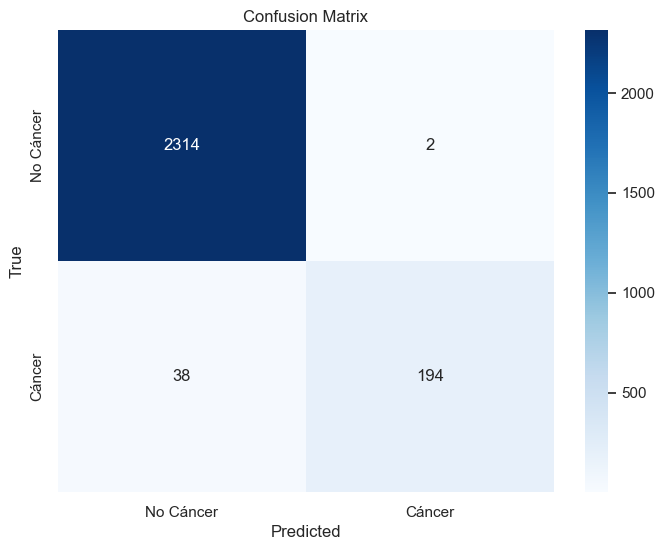

Epoch 1, Training Loss: 0.1227
üîΩ Model saved with F1-Score: 0.9837
Validation Loss: 0.0360
F1 Score: 0.9837, Precision: 0.9844, Recall: 0.9843


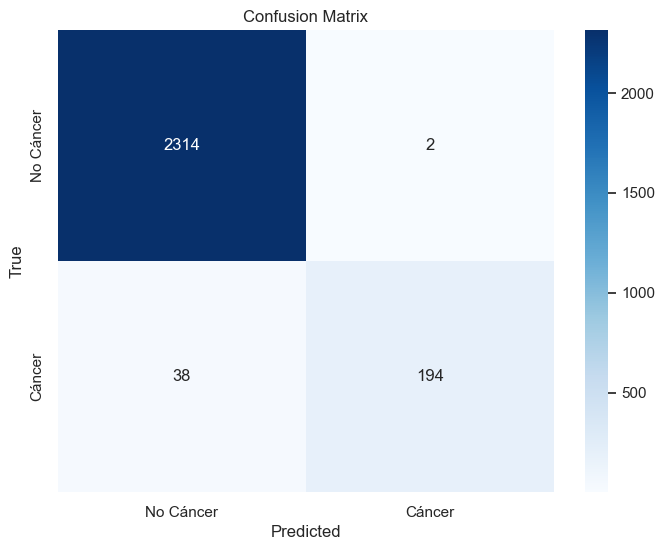

Validation Loss: 0.0336
F1 Score: 0.9806, Precision: 0.9823, Recall: 0.9800


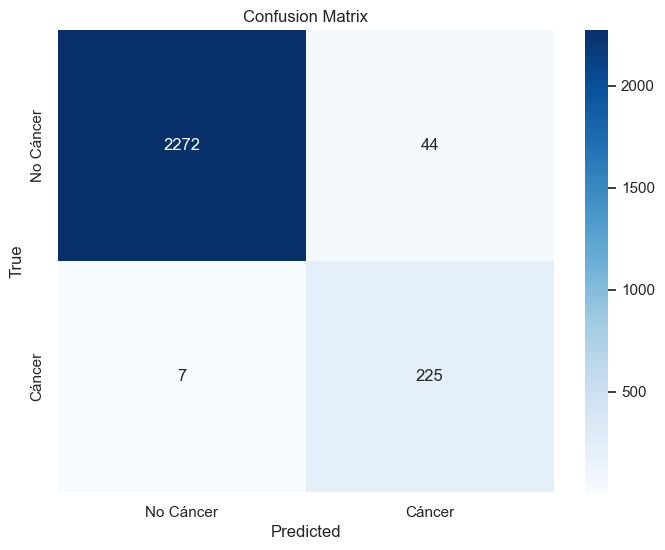

Epoch 2, Training Loss: 0.0422
Validation Loss: 0.0336
F1 Score: 0.9806, Precision: 0.9823, Recall: 0.9800


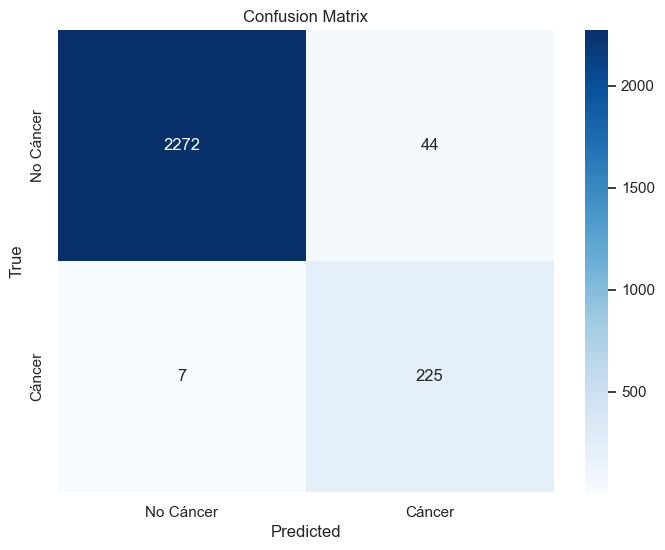

Validation Loss: 0.0364
F1 Score: 0.9782, Precision: 0.9810, Recall: 0.9772


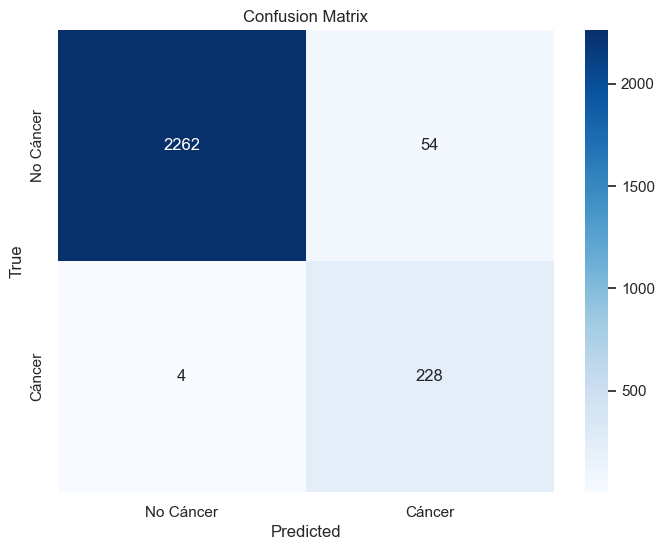

Epoch 3, Training Loss: 0.0398
Validation Loss: 0.0364
F1 Score: 0.9782, Precision: 0.9810, Recall: 0.9772


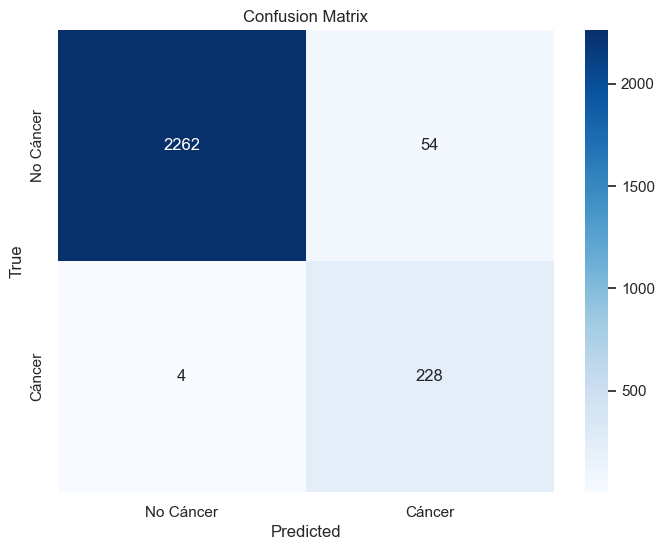

Validation Loss: 0.0395
F1 Score: 0.9828, Precision: 0.9828, Recall: 0.9831


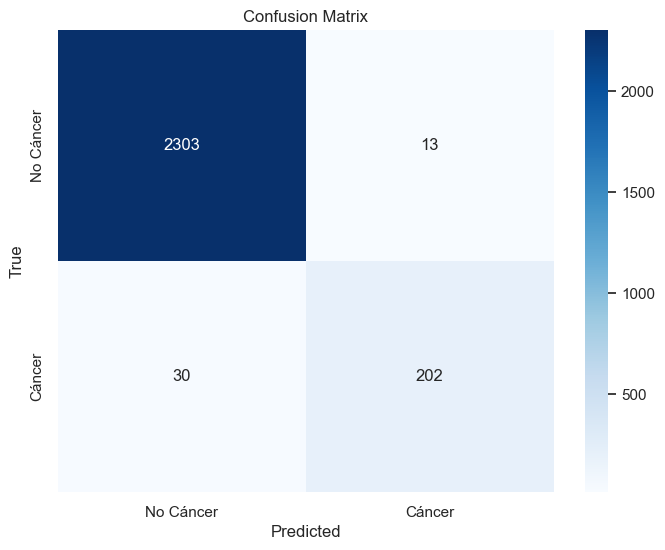

Epoch 4, Training Loss: 0.0399
Validation Loss: 0.0395
F1 Score: 0.9828, Precision: 0.9828, Recall: 0.9831


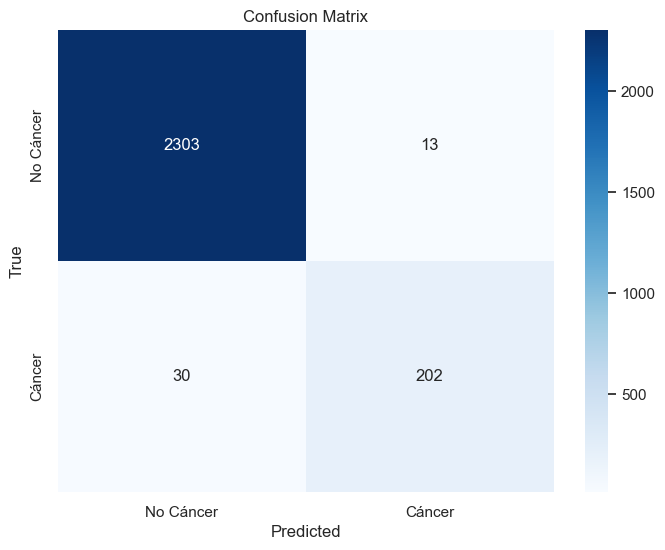

Validation Loss: 0.0297
F1 Score: 0.9846, Precision: 0.9845, Recall: 0.9847


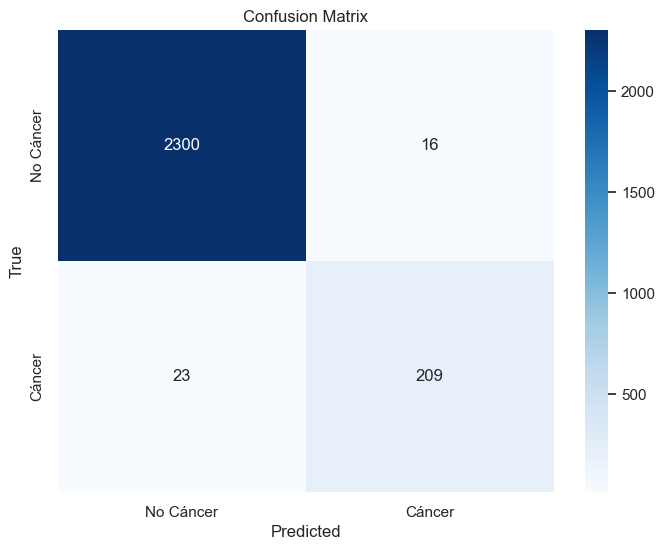

Epoch 5, Training Loss: 0.0369
üîΩ Model saved with F1-Score: 0.9846
Validation Loss: 0.0297
F1 Score: 0.9846, Precision: 0.9845, Recall: 0.9847


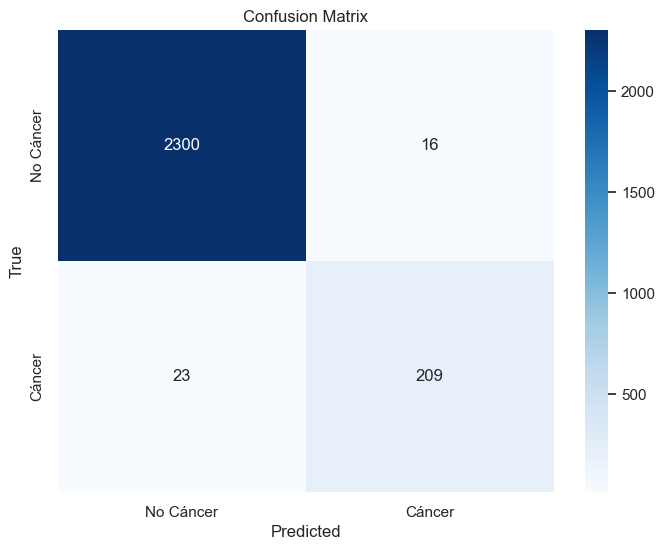

Validation Loss: 0.0294
F1 Score: 0.9843, Precision: 0.9844, Recall: 0.9843


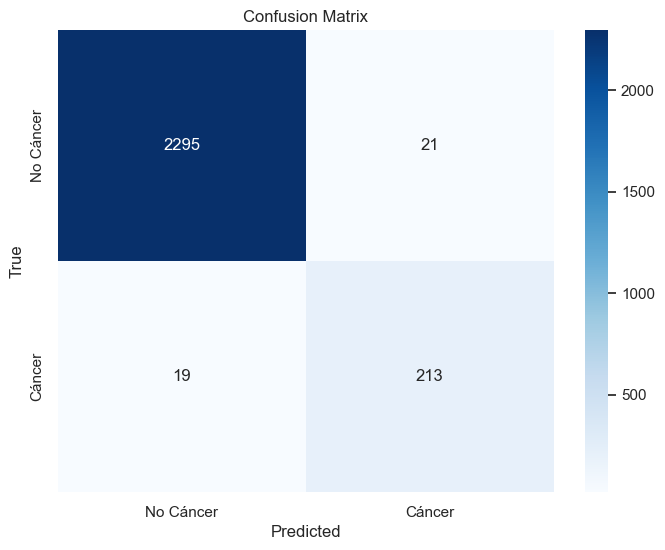

Epoch 6, Training Loss: 0.0361
Validation Loss: 0.0294
F1 Score: 0.9843, Precision: 0.9844, Recall: 0.9843


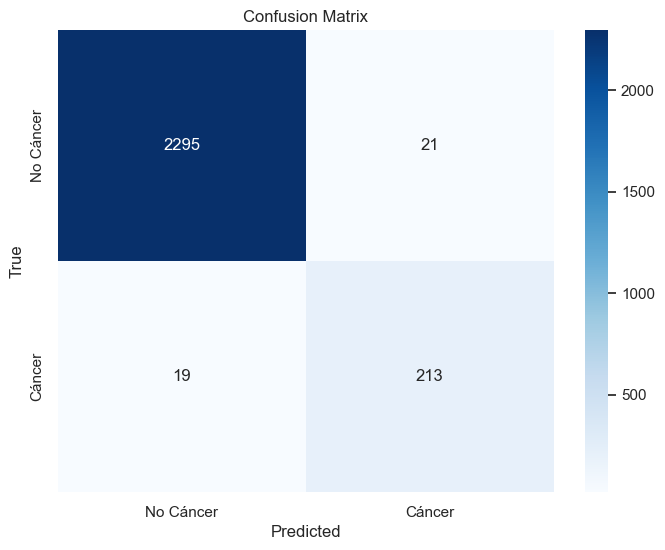

Validation Loss: 0.0301
F1 Score: 0.9840, Precision: 0.9840, Recall: 0.9839


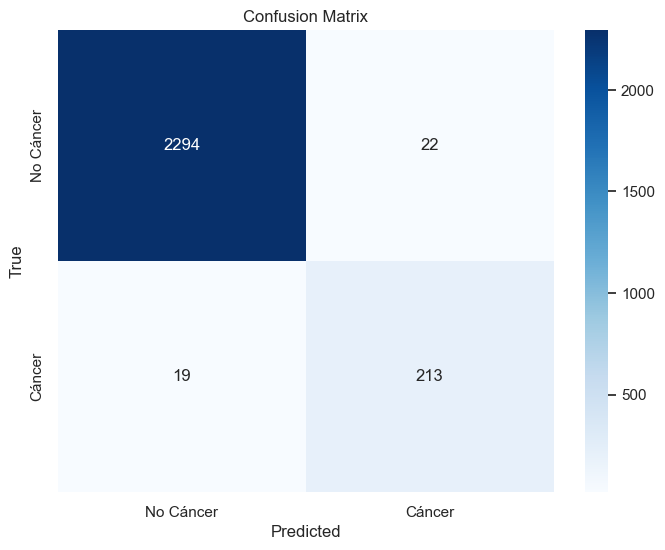

Epoch 7, Training Loss: 0.0363
Validation Loss: 0.0301
F1 Score: 0.9840, Precision: 0.9840, Recall: 0.9839


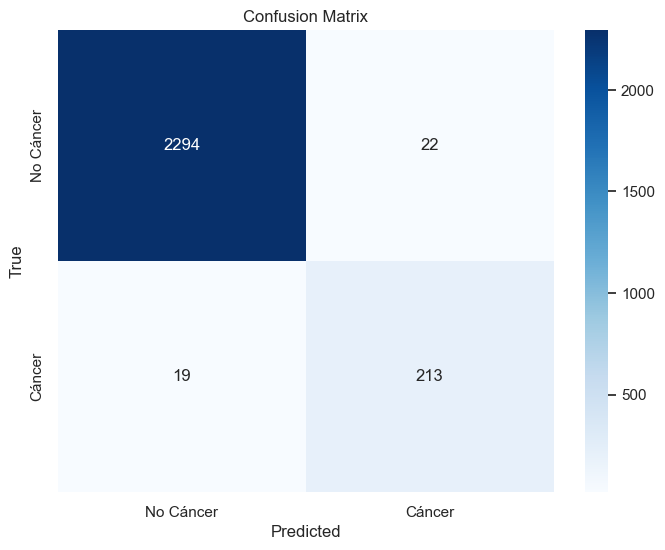

Validation Loss: 0.0299
F1 Score: 0.9825, Precision: 0.9826, Recall: 0.9823


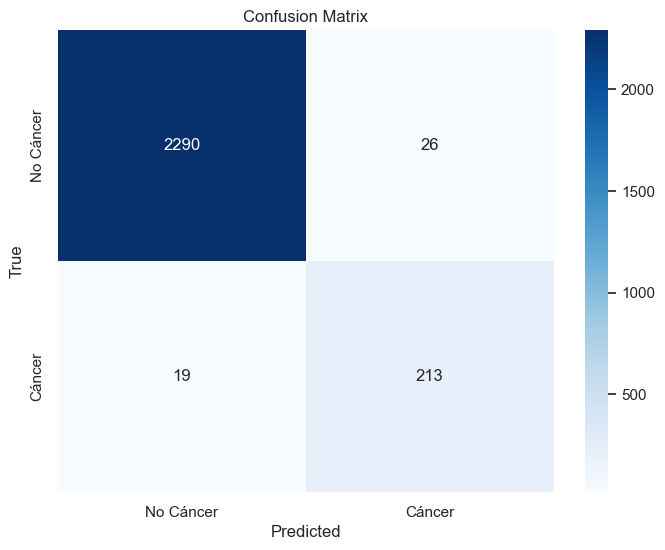

Epoch 8, Training Loss: 0.0361
Validation Loss: 0.0299
F1 Score: 0.9825, Precision: 0.9826, Recall: 0.9823


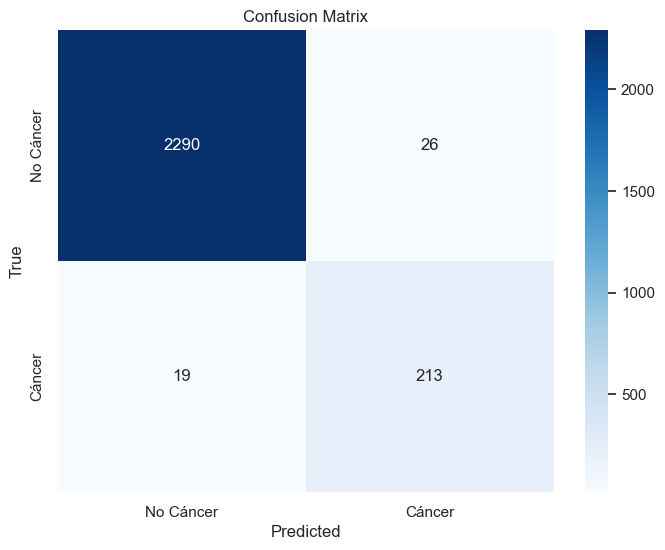

Validation Loss: 0.0302
F1 Score: 0.9849, Precision: 0.9852, Recall: 0.9847


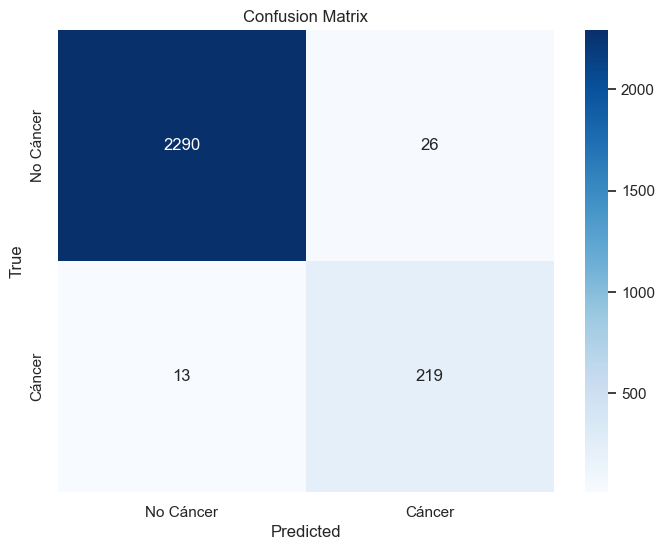

Epoch 9, Training Loss: 0.0354
üîΩ Model saved with F1-Score: 0.9849
Validation Loss: 0.0302
F1 Score: 0.9849, Precision: 0.9852, Recall: 0.9847


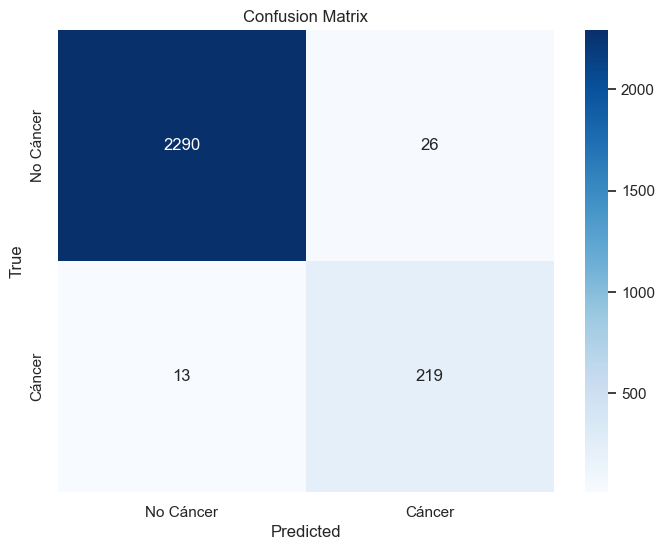

Validation Loss: 0.0325
F1 Score: 0.9796, Precision: 0.9817, Recall: 0.9788


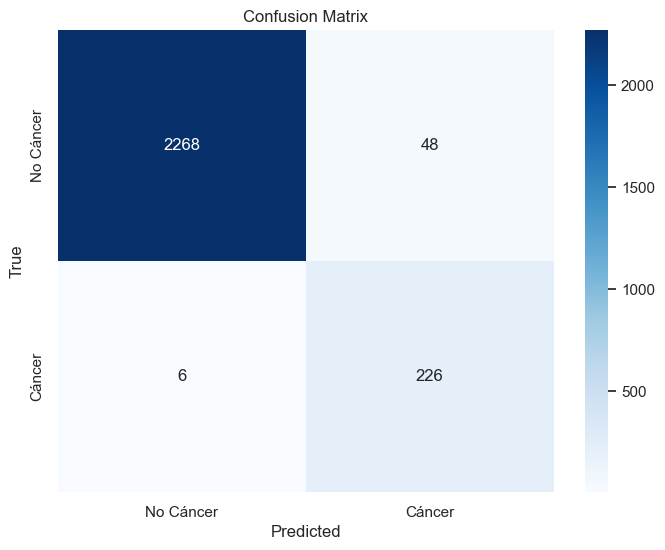

Epoch 10, Training Loss: 0.0358
Validation Loss: 0.0325
F1 Score: 0.9796, Precision: 0.9817, Recall: 0.9788


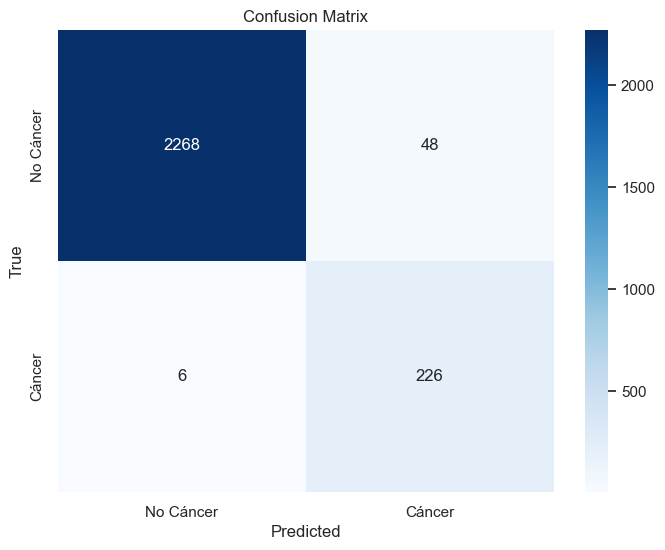

In [142]:
# Inicializar el modelo
num_features = train_features.shape[1] #
model = CombinedModel(num_features=num_features, num_classes=2).to(device)

# Configurar funci√≥n de p√©rdida y optimizador
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# Entrenar el modelo
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10)

In [143]:

def evaluate_model(model, dataloader, criterion):
    model.eval()  # Modo de evaluaci√≥n
    running_loss = 0.0
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for batch_idx, (images, tabular_data, labels) in enumerate(dataloader):
            # Mover datos al dispositivo (GPU o CPU)
            images = images.to(device)
            tabular_data = tabular_data.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images, tabular_data)
            loss = criterion(outputs, labels)

            # Acumular p√©rdida
            running_loss += loss.item()

            # Predicciones y etiquetas verdaderas
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calcular m√©tricas
    average_loss = running_loss / len(dataloader)
    f1 = f1_score(all_labels, all_preds, average="weighted")

    return average_loss, f1

In [144]:
test_loss, test_f1 = evaluate_model(model, val_loader, criterion)
print(f"Test Loss: {test_loss:.4f}, Test F1: {test_f1:.4f}")

Test Loss: 0.0325, Test F1: 0.9796


In [ ]:
torch.save(model.state_dict(), "../streamlit_app/cancer_classification_model_final.pth")

In [147]:
training_tabular_features = train_df_mlo[['age', 'biopsy', 'invasive', 'BIRADS', 'area_segmentada_px', 'otsu_threshold']]

# Durante el entrenamiento
mean = training_tabular_features.mean(axis=0)  # Media de cada columna
std = training_tabular_features.std(axis=0)    # Desviaci√≥n est√°ndar de cada columna

print("Medias:", mean)
print("Desviaciones est√°ndar:", std)

Medias: age                      58.897939
biopsy                    0.121492
invasive                  0.063003
BIRADS                    0.744259
area_segmentada_px    94312.531207
otsu_threshold           77.846811
dtype: float64
Desviaciones est√°ndar: age                      10.061221
biopsy                    0.326714
invasive                  0.242980
BIRADS                    0.601103
area_segmentada_px    52269.074577
otsu_threshold           51.539346
dtype: float64
